# **ПРОЕКТ Анализ лояльности пользователей Яндекс Афиши с помощью Python**

⚡Выполнил Потехин И.С

⁉ *Цель проекта* - провести исследовательский анализ данных чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.




## 🔰 **Содержание проекта**:

1. Загрузка данных и их предобработка.
2. Предобработка данных.
3. Создание профиля пользователя.
4. Исследовательский анализ данных.
5. Общие выводы и рекомендации.

### 🔽 **1. Загрузка данных и их предобработка**
1. Подключение и загрузка необходимых для анализа библиотек

2. Произведем Загрузку данных:
- Выполним подключение в БД *data-analyst-afisha*.
- Отправим SQL-запрос.

3. Проведем знакомство с данными:
- Оценка качества данных и обьем выгрузки


In [88]:
!pip install sqlalchemy
!pip install psycopg2
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
!pip install phik



Подключение к БД:

In [89]:




db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

SQL Запрос на выгрузку данных

In [90]:
query = '''
SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk,
  p.created_ts_msk,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name,
  p.created_dt_msk::date - LAG(p.created_dt_msk::date)
        OVER(PARTITION BY p.user_id ORDER BY p.created_dt_msk)
        AS days_since_prev
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
INNER JOIN afisha.city c ON e.city_id = c.city_id
INNER JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [91]:
df = pd.read_sql_query(query, con=engine)
tmp = df

Изучение полученных данных:

In [92]:
print("\n" + "="*50 + "\n")
print('Основные меры данных:')
print(df.describe())
print("\n" + "="*50 + "\n")
print('Основная информация о данных содержащихся в датасете:')
df.info()
print("\n" + "="*50 + "\n")
print('Названия стобцов датасета:')
print(df.columns)
print("\n" + "="*50 + "\n")
print('Информация о пропусках:')
print(df.isna().sum())
print("\n" + "="*50 + "\n")
print('Первые 5 строк датасета')
print(df.head())
print("\n" + "="*50 + "\n")



Основные меры данных:
           order_id                 created_dt_msk  \
count  2.906110e+05                         290611   
mean   4.326225e+06  2024-09-01 22:36:38.741272576   
min    1.000000e+00            2024-06-01 00:00:00   
25%    2.163618e+06            2024-07-30 00:00:00   
50%    4.326366e+06            2024-09-12 00:00:00   
75%    6.488330e+06            2024-10-09 00:00:00   
max    8.653108e+06            2024-10-31 00:00:00   
std    2.497551e+06                            NaN   

                      created_ts_msk        revenue  tickets_count  \
count                         290611  290611.000000  290611.000000   
mean   2024-09-02 13:31:19.397730816     625.584360       2.754311   
min              2024-06-01 00:00:42     -90.760000       1.000000   
25%       2024-07-30 11:53:37.500000     116.850000       2.000000   
50%              2024-09-12 14:02:10     356.010000       3.000000   
75%       2024-10-09 15:57:55.500000     810.130000       4.000000   

**Выводы**:

1. ***Датасет содержит***:

290611 строк,

15 столбцов:

`user_id`, `device_type_canonical`, `order_id`, `created_dt_msk`,
       `created_ts_msk`, `currency_code`, `revenue`, `tickets_count`,
       `event_id`, `event_name`, `event_type_main`, `service_name`,
       `region_name`, `city_name`, `days_since_prev`

2. ***Пропуски*** обнаруженны в столбце `days_since_prev` - 21933
Это связано с тем что при формировании данного столбца Использовалось условие `Если у пользователя только одна покупка, в этом поле должно быть значение NULL` Поэтому эти пропуски заполним значением-индикатором
3. ***Информация о столбцах***
- `user_id` - уникальный идентификатор пользователя, совершившего заказ содержит в себе численные и буквенные значения - тип данных указан правильно пропуски отсутсвуют
- `device_type_canonical` тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные),тип данных указан правильно пропуски отсутсвуют
- `order_id` - уникальный идентификатор заказа, тип данных указан правильно пропуски отсутсвуют
- `created_dt_msk` -  дата создания заказа,тип данных указан правильно пропуски отсутсвуют
- `created_ts_msk` - дата и время создания заказа, тип данных указан правильно пропуски отсутсвуют
- `currency_code` - валюта оплаты, тип данных указан правильно пропуски отсутсвуют
- `revenue`- выручка от заказа, тип данных указан правильно пропуски отсутсвуют
- `tickets_count` - количество купленных билетов, тип данных указан правильно пропуски отсутсвуют
- `event_id` - уникальный идентификатор мероприятия, тип данных указан правильно пропуски отсутсвуют
- `event_name` - название мероприятия, тип данных указан правильно пропуски отсутсвуют
- `event_type_main` - основной тип мероприятия (театральная постановка, концерт и так далее), тип данных указан правильно пропуски отсутсвуют
- `service_name` - название билетного оператора, тип данных указан правильно пропуски отсутсвуют
- `region_name` - название региона, в котором прошло мероприятие, тип данных указан правильно пропуски отсутсвуют
- `city_name` - название города, в котором прошло мероприятие, тип данных указан правильно пропуски отсутсвуют
- `days_since_prev`- количество дней от предыдущей покупки пользователя, тип данных указан правильно пропуски - 21933
Это связано с тем что при формировании данного столбца Использовалось условие `Если у пользователя только одна покупка, в этом поле должно быть значение NULL` Поэтому эти пропуски заполним значением-индикатором


### 🔽 **2. Предобработка данных**

#### **2.1** **Преобразование валюты к единому формату**
столбец `revenue` содержит данные в тенге, приведем столбец  к единому формату - российский рубль

In [93]:
countkzt = df[df['currency_code'] == 'kzt'].count()
print("\n" + "="*50 + "\n")
print(countkzt)
print("\n" + "="*50 + "\n")




user_id                  5069
device_type_canonical    5069
order_id                 5069
created_dt_msk           5069
created_ts_msk           5069
currency_code            5069
revenue                  5069
tickets_count            5069
event_id                 5069
event_name               5069
event_type_main          5069
service_name             5069
region_name              5069
city_name                5069
days_since_prev          4201
dtype: int64




In [94]:
dfkzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv', sep=',')

In [95]:
print("\n" + "="*50 + "\n")
print(dfkzt.head())
print("\n" + "="*50 + "\n")
print(dfkzt.isna().sum())
print("\n" + "="*50 + "\n")
print(dfkzt.info())
print("\n" + "="*50 + "\n")



         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt


data       0
nominal    0
curs       0
cdx        0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None




Приведем столбец `data` к типу данных datetime64

In [96]:
dfkzt['data'] = pd.to_datetime(dfkzt['data'])

Соеденим два датасета по датам

In [97]:

df = pd.merge(
    df,
    dfkzt,
    left_on=['created_dt_msk', 'currency_code'],
    right_on=['data', 'cdx'],
    how='left'
)



In [98]:
df[df['cdx'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,event_id,event_name,event_type_main,service_name,region_name,city_name,days_since_prev,data,nominal,curs,cdx
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,20.0,2024-09-17,100.0,19.0125,kzt
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,39.0,2024-09-02,100.0,18.9330,kzt
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,NaN,2024-09-09,100.0,18.5991,kzt
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,NaN,2024-06-11,100.0,19.8928,kzt
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1.0,2024-06-04,100.0,19.9833,kzt


Получили датасет который содержит в себе исходный датасет и данные о курсе валюты в этот день:

- `data` дата
- `nominal` - номинал валюты
- `curs` - курс в этот день
- `cdx` - индекс валюты

Удалим ненужные для нас столбцы и произведем расчет перевода столбца со стоимостью заказа для валюты 'тенге' в рубли (Выручка / 100 * Курс в этот день)

In [99]:
df = df.drop(['data','cdx','nominal'], axis=1)

In [100]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,event_id,event_name,event_type_main,service_name,region_name,city_name,days_since_prev,curs
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,NaN,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,NaN,NaN
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,75.0,NaN
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,NaN,NaN
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,83.0,NaN


In [101]:
mask = df['currency_code'] == 'kzt'
df.loc[mask, 'revenue'] = df.loc[mask, 'revenue'] / 100 * df.loc[mask, 'curs']
df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,event_id,event_name,event_type_main,service_name,region_name,city_name,days_since_prev,curs
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,98.503762,4,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,20.0,19.0125
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,65.731589,3,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,39.0,18.9330
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,61.148261,4,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,NaN,18.5991
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,4380.702898,5,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,NaN,19.8928
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,1478.296591,4,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1.0,19.9833


In [102]:
df = df.drop(['curs'], axis=1)

In [103]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,event_id,event_name,event_type_main,service_name,region_name,city_name,days_since_prev
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,NaN
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,75.0
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,NaN
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,83.0


Проверим не образовались ли пропуски в данных:

In [104]:

df.isna().sum()


,0
user_id,0
device_type_canonical,0
order_id,0
created_dt_msk,0
created_ts_msk,0
currency_code,0
revenue,0
tickets_count,0
event_id,0
event_name,0


#### 2.2 Обработка ошибок

1. Обработаем пропущенные значение в столбце `days_since_prev`
2. Уменьшим размерность данных


In [105]:
df['days_since_prev'] = df['days_since_prev'].fillna('-1')

In [106]:
df.isna().sum()

,0
user_id,0
device_type_canonical,0
order_id,0
created_dt_msk,0
created_ts_msk,0
currency_code,0
revenue,0
tickets_count,0
event_id,0
event_name,0


In [107]:

def memory(df, verbose=True):
    # int
    int_columns = ['tickets_count', 'event_id', 'days_since_prev']
    for col in int_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], downcast='integer')

    # float
    float_columns = ['revenue', 'order_id']
    for col in float_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], downcast='float')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    return df

df = memory(df)


In [108]:
print("\n" + "="*50 + "\n")
df.info()
print("\n" + "="*50 + "\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  float32       
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   event_id               290611 non-null  int32         
 9   event_name             290611 non-null  object        
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  ob

Проверяем данные на ошибочные значения и выбросы и дубликаты

In [109]:
print("\n" + "="*50 + "\n")
print(df['device_type_canonical'].unique())
print("\n" + "="*50 + "\n")



['mobile' 'desktop']




In [110]:
print("\n" + "="*50 + "\n")
print(df['currency_code'].unique())
print("\n" + "="*50 + "\n")



['rub' 'kzt']




In [111]:
print("\n" + "="*50 + "\n")
print(df['event_type_main'].unique())
print("\n" + "="*50 + "\n")



['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']




In [112]:
print("\n" + "="*50 + "\n")
print(df['service_name'].unique())
print("\n" + "="*50 + "\n")



['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']




In [113]:
print("\n" + "="*50 + "\n")
print(df['region_name'].unique())
print("\n" + "="*50 + "\n")



['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'Лесодальний край' 'Верхоречная область' 'Горицветская область'
 'Речиновская область' 'Травиницкий округ' 'Сосновская область'
 'Серебринская область' 'Травяная область' 'Каменноярский край'
 'Солнечноземская область' 'Светополянский округ' 'Заречная область'
 'Ручейковский край' 'Глиногорская область' 'Тепляковская область'
 'Каменноозёрный край' 'Солнечнореченская область' 'Зоринский регион'
 'Берёзовская область' 'Лесостепной край' 'Малиновая область'
 'Синегорский регион' 'Луговая область' 'Шанырский регион'
 'Каменополянский округ' 'Речицкая область' 'Горностепной регион'
 'Речицкий регион' 'Золотоключевской край' 'Лесоярская область'
 'Зеленоградский ок

In [114]:
print("\n" + "="*50 + "\n")
print(df['city_name'].unique())
print("\n" + "="*50 + "\n")



['Глиногорск' 'Озёрск' 'Родниковецк' 'Кристалевск' 'Дальнозолотск'
 'Радужнополье' 'Радужсвет' 'Кумсай' 'Верховино' 'Светополье' 'Кокжар'
 'Каменский' 'Лесоярич' 'Никольянов' 'Речинцево' 'Лесозолотск'
 'Дальнозерск' 'Серебрянка' 'Островецк' 'Родниковец' 'Дальнесветск'
 'Луговаярово' 'Ягодиновка' 'Дальнополин' 'Солчелуг' 'Озёрчане'
 'Серебровино' 'Лесоярово' 'Глинополье' 'Глиноград' 'Дальнесветин'
 'Северополье' 'Теплоозеро' 'Горнодолинск' 'Ордакент' 'Озёрово'
 'Луговинск' 'Лугоград' 'Златопольск' 'Крутовинск' 'Сарыжар' 'Сосновечин'
 'Тихоярск' 'Яблонецк' 'Жаркентай' 'Широковка' 'Синеводов' 'Синеводск'
 'Тихосветск' 'Радужанов' 'Каменосветск' 'Глиногорь' 'Родниковск'
 'Травогород' 'Глинянск' 'Радужинск' 'Поляногорье' 'Дальнолесье'
 'Ручейник' 'Ключеград' 'Ключеводск' 'Поленовино' 'Речичанск'
 'Ключевополье' 'Шаныртау' 'Дальнесоснов' 'Ордасай' 'Теплоозёрск'
 'Чистогорье' 'Островярово' 'Ручейный' 'Ягодинск' 'Поленоозёрово'
 'Акбасты' 'Медовино' 'Каменёвка' 'Рощино' 'Солнечнёвка' 'Верхоз

In [115]:
def boxplots(df, columns):
    """
    Боксплот для нескольких столбцов
    Parameters:
    df - датасет
    columns - список столбцов
    """
    n_cols = len(columns)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 6))

    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(columns):
        axes[i].boxplot(df[col].dropna())
        axes[i].set_title(f'Boxplot for: {col}')
        axes[i].set_ylabel(col)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

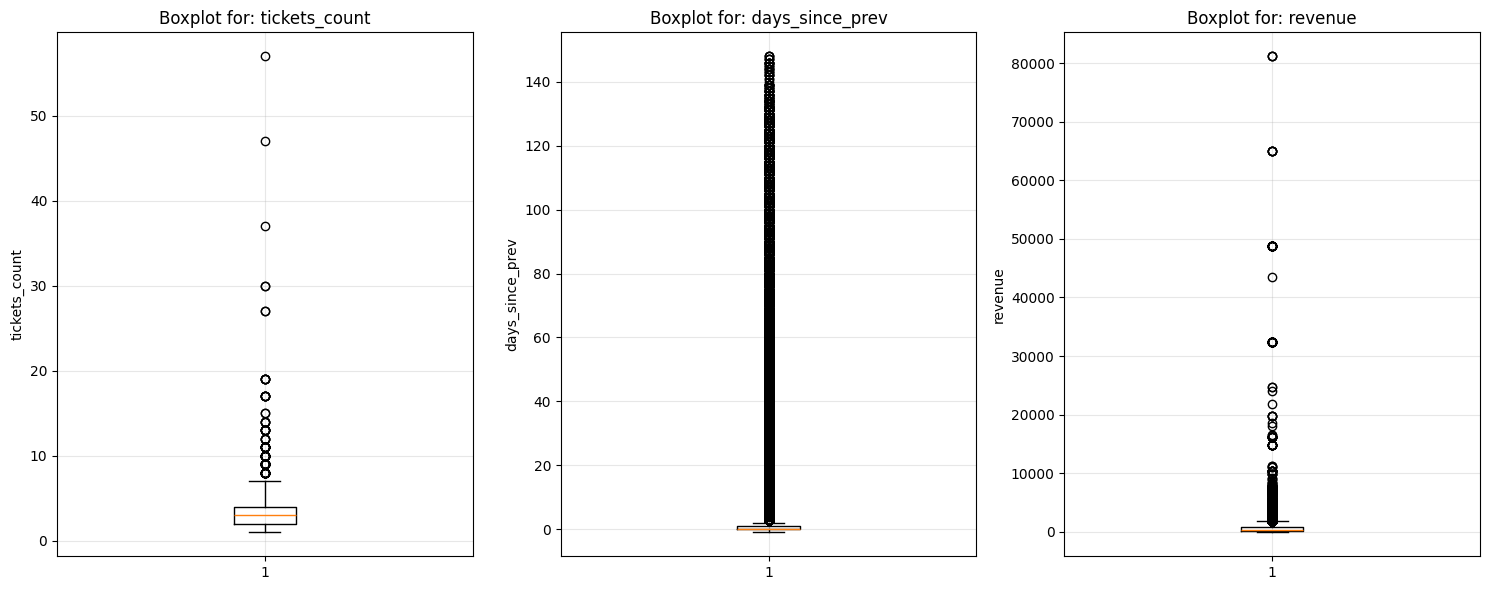

In [116]:
boxplots(df, ['tickets_count','days_since_prev','revenue'])

In [117]:
def histograms(df, columns=None, bins=30, figsize=(15, 10)):
    """
    Построение гистрограммы для изучения распределения данных в столбцах
    Параметры
    df - датасет
    columns - список столбцов
    bins -бины
    figsize - размер графика
    """
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, column in enumerate(columns):
        if i < len(axes):
            axes[i].hist(df[column].dropna(), bins=bins, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение: {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)

    # Скрываем пустые subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


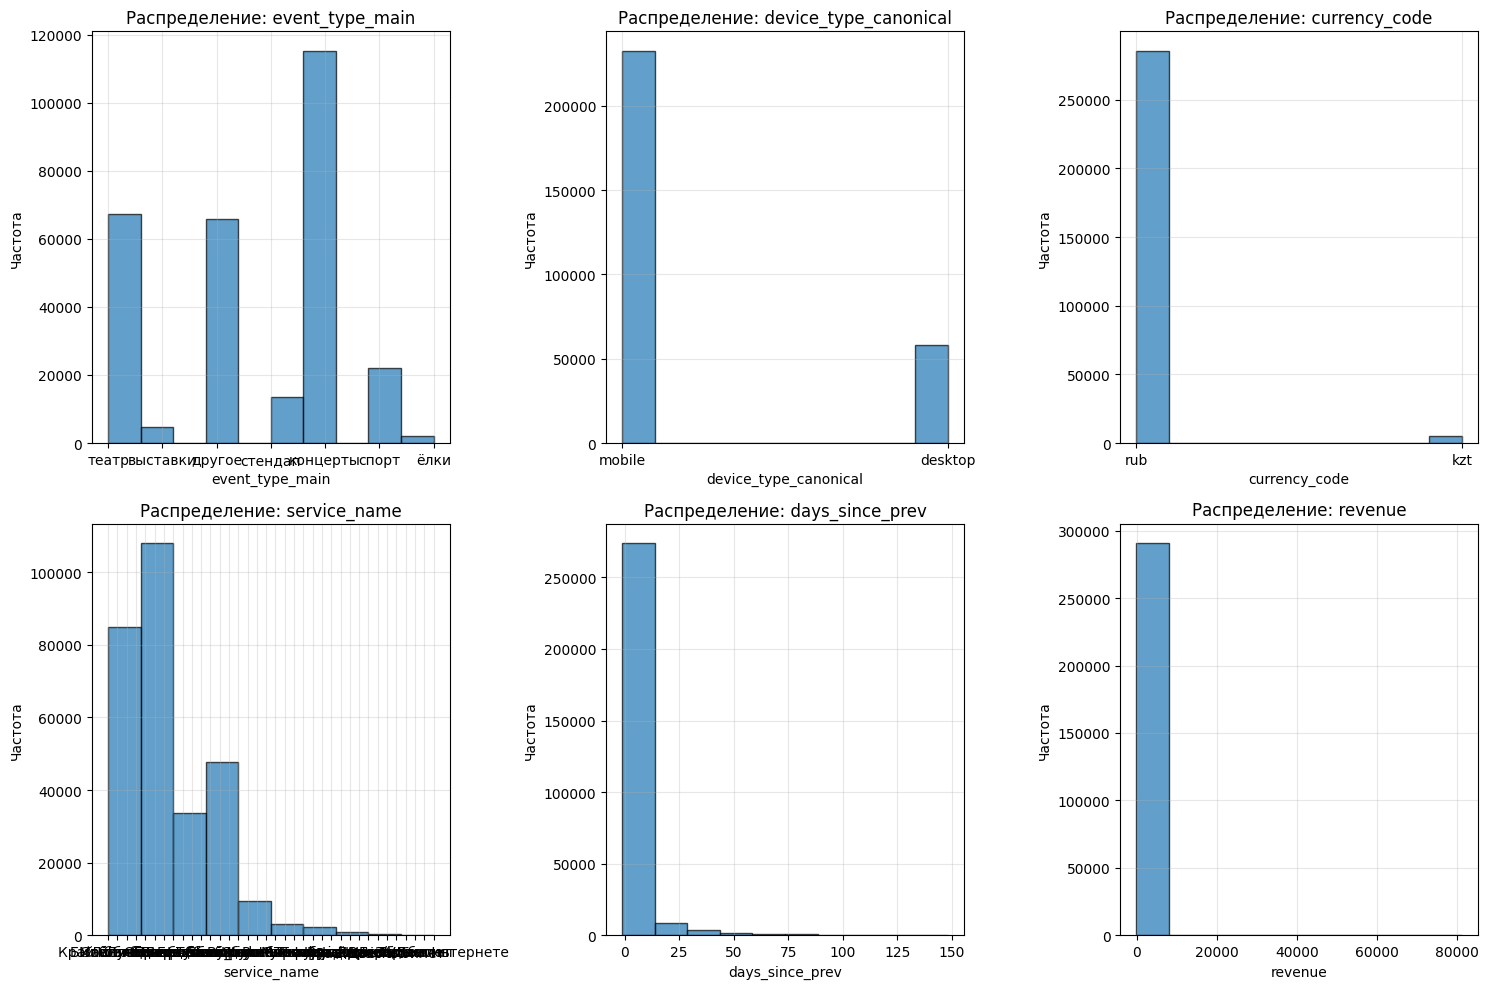

In [118]:
histograms(df=df, columns=['event_type_main','device_type_canonical','currency_code','service_name','days_since_prev','revenue'], bins=10)

In [119]:
df['service_name'].groupby(df['service_name']).count().sort_values()

,service_name
service_name,
Билеты в интернете,4
Зе Бест!,5
Лимоны,8
Тех билет,22
Цвет и билет,61
Кино билет,67
Дырокол,74
Вперёд!,80
Билет по телефону,85


Аномалий в данных не обнаружено

In [120]:
df.duplicated().sum()

np.int64(0)

Проверка на неявные дубликаты

In [121]:
df.duplicated(['order_id','user_id']).sum()

np.int64(0)

Дубликаты не обнаружены

**Вывод**:

Было проведено:
- Замена пропущенных данных значением-индикатором '-1'
- Преобразовали валюту тенге в российский рублю согласно курсу
- проверили данные на выбросы и аномальные значения
- проверили данные на дубликаты явные/неявные

В целом датасет представляет собой хороший набор данных для дальнейшего анализа

In [122]:
print("\n" + "="*50 + "\n")
print(f'Было строк в исходном датасете: {len(tmp)}\n Осталось строк в датасете после обработки:{len(df)}\n Удалено строк в датасете после обработки:{len(tmp) - len(df)}\n Процент потерь:{(round((len(tmp) - len(df)) / len(tmp) * 100, 2))}')
print("\n" + "="*50 + "\n")



Было строк в исходном датасете: 290611
 Осталось строк в датасете после обработки:290611
 Удалено строк в датасете после обработки:0
 Процент потерь:0.0




### 🔽 **3. Создание профиля пользователя.**

#### **3.1 Построение профиля пользователя**

Для каждого пользователя найдем:
- Дата первого и последнего заказа
- устройство с которого был сделан первый заказ
- регион, в котором был сделан первый заказ
- Билетный партнер
- Жанр первого мероприятия посещенного пользователем
- общее количество заказов средняя выручка с одного заказа в рублях
- среднее колличество билетов в заказе
- среднее время между заказами
- узнать совершил ли пользователь больше 2 и 5 заказов

In [123]:
print("\n" + "="*50 + "\n")
df.info()
print("\n" + "="*50 + "\n")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  float32       
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   event_id               290611 non-null  int32         
 9   event_name             290611 non-null  object        
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  ob

In [124]:
def create_user_profile(df):
    """
    функция создания профиля пользователя
    df - датасет
    """
    #резерв копия
    df_work = df[['user_id', 'created_ts_msk', 'region_name', 'service_name',
                  'event_type_main', 'revenue', 'tickets_count', 'days_since_prev',
                  'device_type_canonical']].copy()

    df_work = df_work.sort_values(['user_id', 'created_ts_msk'])

    # нумерация заказа польз
    df_work['order_rank'] = df_work.groupby('user_id').cumcount() + 1

    first_orders = df_work[df_work['order_rank'] == 1].copy()

    user_agg = df_work.groupby('user_id').agg({
        'created_ts_msk': ['min', 'max'],
        'revenue': 'mean',
        'tickets_count': 'mean',
        'days_since_prev': 'mean',
        'order_rank': 'count'
    }).reset_index()

    user_agg.columns = ['user_id', 'first_order_date', 'last_order_date',
                       'avg_revenue', 'avg_tickets_count', 'avg_days_between_orders',
                       'total_orders']

    result = user_agg.merge(
        first_orders[['user_id', 'region_name', 'service_name', 'event_type_main',
                     'device_type_canonical']],
        on='user_id',
        how='left'
    )

    result = result.rename(columns={
        'region_name': 'first_region',
        'service_name': 'first_service',
        'event_type_main': 'first_event_type',
        'device_type_canonical': 'first_device'
    })

    # добавление новых признаков
    result['is_two'] = (result['total_orders'] > 2).astype(int)
    result['is_five'] = (result['total_orders'] > 5).astype(int)

    return result

In [125]:
profile_of_user = create_user_profile(df)

In [126]:
profile_of_user.head()

,user_id,first_order_date,last_order_date,avg_revenue,avg_tickets_count,avg_days_between_orders,total_orders,first_region,first_service,first_event_type,first_device,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1521.940000,4.000000,-1.000000,1,Каменевский регион,Край билетов,театр,mobile,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,774.010000,3.000000,37.000000,2,Каменевский регион,Мой билет,выставки,mobile,0,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,767.213333,2.666667,33.666667,3,Североярская область,Лови билет!,другое,mobile,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,917.830000,4.000000,-1.000000,1,Каменевский регион,Край билетов,театр,desktop,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,61.310000,1.500000,7.500000,2,Поленовский край,Лучшие билеты,театр,mobile,0,0


In [127]:
print("\n" + "="*50 + "\n")
profile_of_user.info()
print("\n" + "="*50 + "\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21933 entries, 0 to 21932
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21933 non-null  object        
 1   first_order_date         21933 non-null  datetime64[ns]
 2   last_order_date          21933 non-null  datetime64[ns]
 3   avg_revenue              21933 non-null  float64       
 4   avg_tickets_count        21933 non-null  float64       
 5   avg_days_between_orders  21933 non-null  float64       
 6   total_orders             21933 non-null  int64         
 7   first_region             21933 non-null  object        
 8   first_service            21933 non-null  object        
 9   first_event_type         21933 non-null  object        
 10  first_device             21933 non-null  object        
 11  is_two                   21933 non-null  int64         
 12  is_five                  21933

**Выводы**

Был создан новый датасет **`profile_of_user`** с профилем пользователя:
- `user_id` - уникальный номер пользователя;
- `first_order_date` - дата первого заказа;
- `last_order_date` - дата последнего заказа;
- `avg_revenue` - средняя выручка с одного заказа в рублях;
- `avg_tickets_count` - среднее количество билетов в заказе;
- `avg_days_between_orders` - среднее время между заказами (выраженное в днях);
- `total_orders` - общее количество заказов;
- `is_two` - совершил ли пользователь больше двух заказов (бинарное значения);
- `is_five` - совершил ли пользователь больше пяти заказов (бинарное значение);
- `first_region` - регион, в котором был сделан первый заказ;
- `first_service` - билетного партнёра, к которому обращались при первом заказе;
- `first_event_Type` - жанр первого посещённого мероприятия
- `first_device` - устройство, с которого был сделан первый заказ

#### **3.2 Оценка репрезентативности данных и поиск аномалий**

Произведем рассчет:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших более 2 и более 5 заказов.

Изучим статистические показатели:
- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

In [128]:
print("\n" + "="*50 + "\n")
print(f"✅общее число пользователей в выборке {profile_of_user['user_id'].nunique()}")
print("\n" + "="*50 + "\n")



✅общее число пользователей в выборке 21933




In [129]:
print("\n" + "="*50 + "\n")
print(f"✅Cредняя выручка с одного заказа {round(profile_of_user['avg_revenue'].mean(), 2)}")
print("\n" + "="*50 + "\n")



✅Cредняя выручка с одного заказа 574.02




In [130]:
print("\n" + "="*50 + "\n")
print(f"👤👤✅>2 заказов: {(profile_of_user['total_orders'] > 2).mean():.2%}")
print("\n" + "="*50 + "\n")
print(f"👤👤👤👤👤✅>5 заказов: {(profile_of_user['total_orders'] > 5).mean():.2%}")
print("\n" + "="*50 + "\n")



👤👤✅>2 заказов: 45.49%


👤👤👤👤👤✅>5 заказов: 24.71%




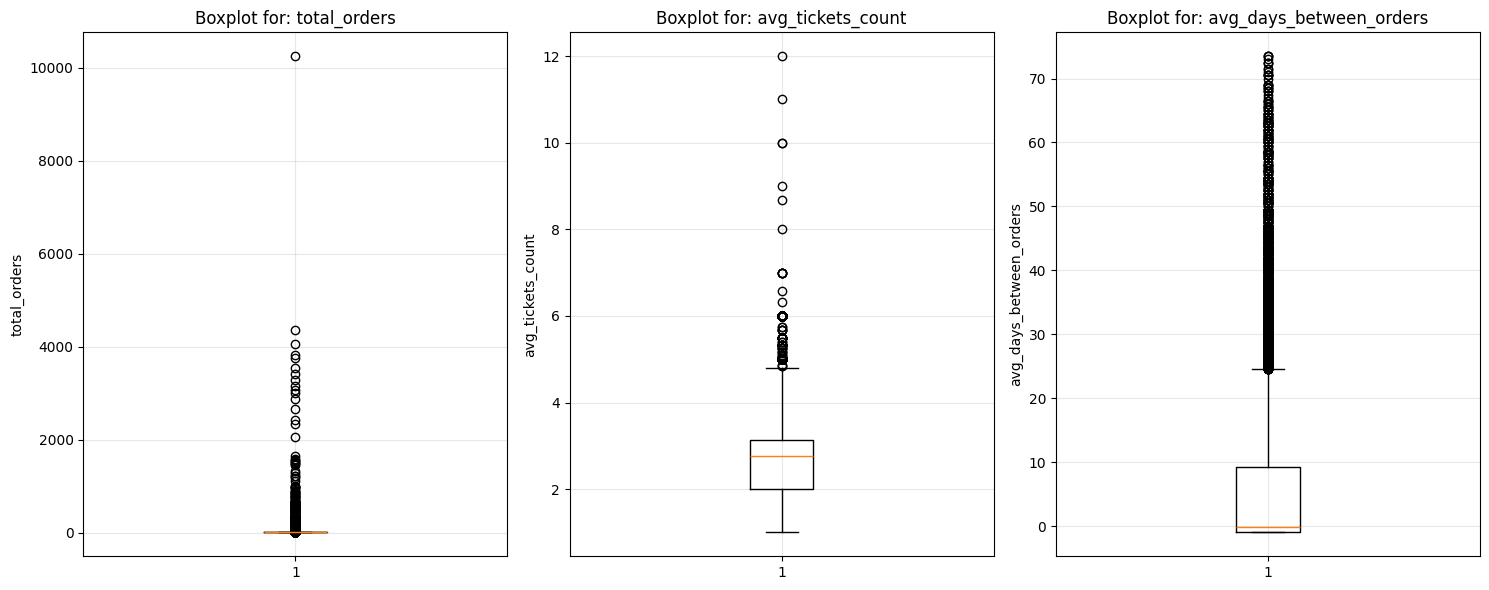

In [131]:
boxplots(profile_of_user,['total_orders','avg_tickets_count','avg_days_between_orders'])

In [132]:
profile_of_user[['total_orders','avg_tickets_count','avg_days_between_orders']].describe()

,total_orders,avg_tickets_count,avg_days_between_orders
count,21933.000000,21933.000000,21933.000000
mean,13.249943,2.755987,5.961859
std,122.470535,0.920739,11.080418
min,1.000000,1.000000,-1.000000
25%,1.000000,2.000000,-1.000000
50%,2.000000,2.764151,-0.166667
75%,5.000000,3.125000,9.200000
max,10251.000000,12.000000,73.500000


В столбцах `avg_tickets_count` существенных аномалий влияющих на анализ не обнаруженно, при анализе будет учитывать весь набор, `avg_days_between_orders` существенных аномалий влияющих на анали не обнаруженно, при анализе не будем учитывать значения индикатор
в свою очередь в столбце `total_orders` присутсвуют аномальные значения, стоит рассмотреть их по лучше

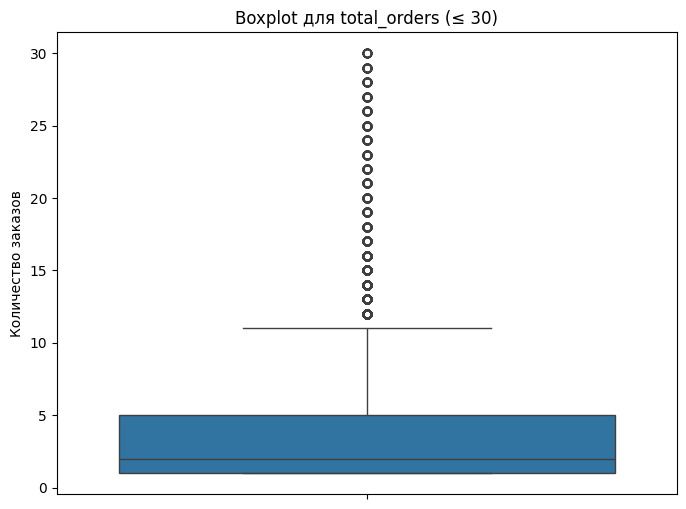

In [133]:
filtered_data = profile_of_user[profile_of_user['total_orders'] <= 30]
plt.figure(figsize=(8, 6))
sns.boxplot(y=filtered_data['total_orders'])
plt.title('Boxplot для total_orders (≤ 30)')
plt.ylabel('Количество заказов')
plt.show()

In [134]:
print("\n" + "="*50 + "\n")
print(f"Значений > 10: {(profile_of_user['total_orders'] > 10).sum()} ({(profile_of_user['total_orders'] > 10).mean()*100:.2f}%)")
print("\n" + "="*50 + "\n")



Значений > 10: 3020 (13.77%)




In [135]:
data = profile_of_user['total_orders']
percentile_99 = data.quantile(0.99)
print("\n" + "="*50 + "\n")
print(f"99-й процентиль: {percentile_99}")
print("\n" + "="*50 + "\n")
percentile_95 = data.quantile(0.95)
print(f"95-й процентиль: {percentile_95}")
print("\n" + "="*50 + "\n")




99-й процентиль: 152.0


95-й процентиль: 32.0




Удалим аномалии из данных, т.к для последующего использования этих данных в построении модели они будут плохо сказываться на обучении

In [136]:
result_user_profile = profile_of_user[profile_of_user['total_orders'] <= percentile_95]

In [137]:
result_user_profile.describe()

,first_order_date,last_order_date,avg_revenue,avg_tickets_count,avg_days_between_orders,total_orders,is_two,is_five
count,20864,20864,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000
mean,2024-08-13 15:19:13.898820864,2024-09-16 22:00:56.904332800,575.920150,2.756520,6.161730,4.108081,0.426956,0.208541
min,2024-06-01 00:01:58,2024-06-01 01:29:40,-10.770000,1.000000,-1.000000,1.000000,0.000000,0.000000
25%,2024-06-30 19:52:18.500000,2024-08-22 17:25:47.249999872,204.980000,2.000000,-1.000000,1.000000,0.000000,0.000000
50%,2024-08-13 16:21:01,2024-10-01 06:45:54,465.379038,2.777778,-0.333333,2.000000,0.000000,0.000000
75%,2024-09-24 23:38:14.750000128,2024-10-20 18:26:50,798.905313,3.187500,9.800000,5.000000,1.000000,0.000000
max,2024-10-31 23:55:27,2024-10-31 23:59:54,16738.696667,12.000000,73.500000,32.000000,1.000000,1.000000
std,NaN,NaN,569.276774,0.941957,11.321338,5.239384,0.494648,0.406275


In [138]:
print("\n" + "="*50 + "\n")
result_user_profile.info()
print("\n" + "="*50 + "\n")



<class 'pandas.core.frame.DataFrame'>
Index: 20864 entries, 0 to 21932
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  20864 non-null  object        
 1   first_order_date         20864 non-null  datetime64[ns]
 2   last_order_date          20864 non-null  datetime64[ns]
 3   avg_revenue              20864 non-null  float64       
 4   avg_tickets_count        20864 non-null  float64       
 5   avg_days_between_orders  20864 non-null  float64       
 6   total_orders             20864 non-null  int64         
 7   first_region             20864 non-null  object        
 8   first_service            20864 non-null  object        
 9   first_event_type         20864 non-null  object        
 10  first_device             20864 non-null  object        
 11  is_two                   20864 non-null  int64         
 12  is_five                  20864 non-

In [139]:
print("\n" + "="*50 + "\n")
print(f'Было строк в исходном датасете: {len(profile_of_user)}\n Осталось строк в датасете после обработки:{len(result_user_profile)}\n Удалено строк в датасете после обработки:{len(profile_of_user) - len(result_user_profile)}\n Процент потерь:{(round((len(profile_of_user) - len(result_user_profile)) / len(profile_of_user) * 100, 2))}')
print("\n" + "="*50 + "\n")



Было строк в исходном датасете: 21933
 Осталось строк в датасете после обработки:20864
 Удалено строк в датасете после обработки:1069
 Процент потерь:4.87




**Вывод**

- Для дальнешего анализа будем использовать 95 процентиль(Ограничил итоговый датасет result_user_profile
- в остальных столбцах аномалий не было обнаруженно
- общее число пользователей в выборке  - **`21933`**
- Cредняя выручка с одного заказа **`574.02`**
- > больше 2 заказов: **`45.49%`**
- > больше 5 заказов: **`24.71%`**

### 🔽 **4. Исследовательский анализ данных**

На этом этапе нам необходимо  провести исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа

#### **4.1. Исследование признаков первого заказа и их связи с возвращением на платформу**

##### **4.1.1 Изучение распределение пользователей по признакам**

Произведем расчет на общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака:
- по типу их первого мероприятия;
- по типу устройства, с которого совершена первая покупка;
- по региону проведения мероприятия из первого заказа;
- по билетному оператору, продавшему билеты на первый заказ.

Выделим столбец `two_and_more` который принимает бинарные значение 1 - 2 и больше заказа, 0 -  меньше 2 заказов

In [140]:
result_user_profile['two_and_more'] = np.where(result_user_profile['total_orders'] >= 2, 1, 0)

/tmp/ipython-input-1410138833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['two_and_more'] = np.where(result_user_profile['total_orders'] >= 2, 1, 0)


In [141]:
first_event = result_user_profile.groupby('first_event_type')
event_counts = first_event['user_id'].count()
event_sorted = event_counts.sort_values(ascending=False)

total_users = event_counts.sum()
result_df = pd.DataFrame({
    'count': event_sorted,
    '%': (event_sorted / total_users * 100).round(2)
})
print("\n" + "="*50 + "\n")
print(result_df)
print("\n" + "="*50 + "\n")



                  count      %
first_event_type              
концерты           9255  44.36
другое             5181  24.83
театр              4098  19.64
стендап            1069   5.12
спорт               768   3.68
выставки            399   1.91
ёлки                 94   0.45




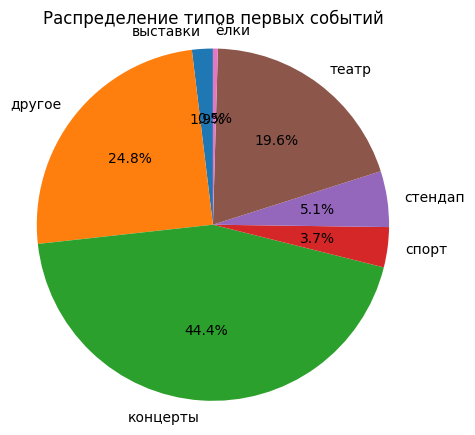

In [142]:
event_counts = first_event['user_id'].count()
plt.figure(figsize=(5, 5))
plt.pie(event_counts.values, labels=event_counts.index, autopct='%0.1f%%', startangle=90)
plt.title('Распределение типов первых событий')
plt.axis('equal')
plt.show()

Данные распределенны не равномерно

2 "точки входа" - концерты, другое, театр :
- концерты           `9255`  `44.36%`
- другое             `5181`  `24.83%`
- театр              `4098`  `19.64%`

In [143]:
first_device = result_user_profile.groupby('first_device')
print("\n" + "="*50 + "\n")
print(first_device['user_id'].count())
print("\n" + "="*50 + "\n")



first_device
desktop     3569
mobile     17295
Name: user_id, dtype: int64




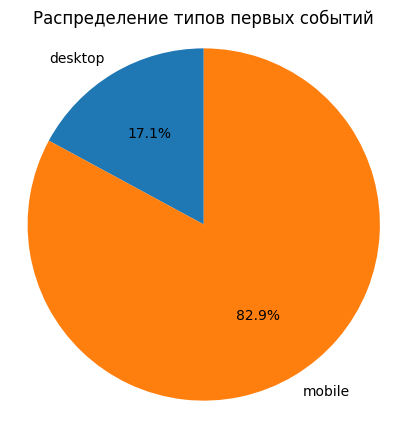

In [144]:
device_counts = first_device['user_id'].count()
plt.figure(figsize=(5, 5))
plt.pie(device_counts.values, labels=device_counts.index, autopct='%0.1f%%', startangle=90)
plt.title('Распределение типов первых событий')
plt.axis('equal')
plt.show()

Ощутимое большиство преобладают пользователи которые начали пользоваться сервисом впервые - мобильное приложение `82.9%` - `17295` пользователей

In [145]:
first_region = result_user_profile.groupby('first_region')
region_counts = first_region['user_id'].count()
region_sorted = region_counts.sort_values(ascending=False).head(50)

total_users = region_counts.sum()
region_with_percent = (region_sorted / total_users * 100).round(2)
result_df = pd.DataFrame({
    'count': region_sorted,
    '%': region_with_percent
})
print("\n" + "="*50 + "\n")
print(result_df)
print("\n" + "="*50 + "\n")



                           count      %
first_region                           
Каменевский регион          6841  32.79
Североярская область        3599  17.25
Широковская область         1193   5.72
Озернинский край             663   3.18
Малиновоярский округ         522   2.50
Травяная область             470   2.25
Шанырский регион             470   2.25
Светополянский округ         441   2.11
Речиновская область          419   2.01
Яблоневская область          401   1.92
Верхоречная область          386   1.85
Медовская область            358   1.72
Лугоградская область         346   1.66
Серебринская область         323   1.55
Тепляковская область         308   1.48
Солнечнореченская область    286   1.37
Солнечноземская область      276   1.32
Горицветская область         230   1.10
Глиногорская область         213   1.02
Зоринский регион             203   0.97
Лесодальний край             189   0.91
Заречная область             187   0.90
Речицкий регион              183   0.8

Представленно большое количество регионов

Точки входа:

- Каменевский регион  -        `6841`  `32.79%`
- Североярская область  -      `3599`  `17.25%`
- Широковская область   -      `1193`   `5.72%`

In [146]:
first_service = result_user_profile.groupby('first_service')
service_counts = first_service['user_id'].count()
service_sorted = service_counts.sort_values(ascending=False).head(50)
total_users = service_counts.sum()
service_with_percent = (service_sorted / total_users * 100).round(2)

result_df = pd.DataFrame({
    'count': service_sorted,
    '%': service_with_percent
})
print("\n" + "="*50 + "\n")
print(result_df)
print("\n" + "="*50 + "\n")



                        count      %
first_service                       
Билеты без проблем       4985  23.89
Мой билет                2884  13.82
Лови билет!              2715  13.01
Билеты в руки            2424  11.62
Облачко                  2113  10.13
Весь в билетах           1248   5.98
Лучшие билеты            1130   5.42
Прачечная                 554   2.66
Край билетов              442   2.12
Дом культуры              339   1.62
Яблоко                    309   1.48
Тебе билет!               299   1.43
Городской дом культуры    211   1.01
За билетом!               198   0.95
Мир касс                  195   0.93
Show_ticket               161   0.77
Быстробилет               160   0.77
Выступления.ру             94   0.45
Восьмёрка                  83   0.40
Быстрый кассир             54   0.26
Росбилет                   51   0.24
Crazy ticket!              42   0.20
Радио ticket               36   0.17
Телебилет                  27   0.13
Реестр                     27   0.13

Наиболее популярные сервисы имеющие больше 10% первоначальных пользователей:
- Билеты без проблем       `4985`  `23.89%`
- Мой билет                `2884`  `13.82%`
- Лови билет!              `2715`  `13.01%`
- Билеты в руки            `2424`  `11.62%`
- Облачко                  `2113`  `10.13%`

**Вывод**

Проведен анализ распределения пользователей по ключевым признакам первого заказа.

Основные точки входа по типам мероприятий:

концерты - 44.36% (9255 пользователей)

другие мероприятия - 24.83% (5181)

театр - 19.64% (4098)

Преобладающим каналом первого заказа стало мобильное приложение - 82.9% (17295 пользователей).

По географическому распределению выделились три основных региона:

Каменевский регион - 32.79% (6841)

Североярская область - 17.25% (3599)

Широковская область - 5.72% (1193)

Среди билетных операторов наиболее популярными стали:

"Билеты без проблем" - 23.89% (4985)

"Мой билет" - 13.82% (2884)

"Лови билет!" - 13.01% (2715)

"Билеты в руки" - 11.62% (2424)

"Облачко" - 10.13% (2113)

Распределение пользователей по всем анализируемым признакам оказалось неравномерным.

##### **4.1.2. Анализ возврата пользователей:**

Вычисление доли пользователей совершивших 2 и более 2 заказов для каждого сегмента

In [147]:
pivot_event = result_user_profile.pivot_table(
    index='first_event_type',
    columns='two_and_more',
    values=None,
    aggfunc='size',
)

print("Количество:")
print(pivot_event)
print("\n" + "="*50 + "\n")

pivot_percentage = pivot_event.div(pivot_event.sum(axis=1), axis=0) * 100

print("Доли по строкам (% от общего для каждого события):")
print(pivot_percentage.round(2))
print("\n" + "="*50 + "\n")

pivot_total_percentage = pivot_event.div(pivot_event.sum()) * 100

print("Доли от общего количества (%):")
print(pivot_total_percentage.round(2))
print("\n" + "="*50 + "\n")


Количество:
two_and_more         0     1
first_event_type            
выставки           149   250
другое            2189  2992
концерты          3648  5607
спорт              352   416
стендап            436   633
театр             1557  2541
ёлки                43    51


Доли по строкам (% от общего для каждого события):
two_and_more          0      1
first_event_type              
выставки          37.34  62.66
другое            42.25  57.75
концерты          39.42  60.58
спорт             45.83  54.17
стендап           40.79  59.21
театр             37.99  62.01
ёлки              45.74  54.26


Доли от общего количества (%):
two_and_more          0      1
first_event_type              
выставки           1.78   2.00
другое            26.14  23.96
концерты          43.56  44.89
спорт              4.20   3.33
стендап            5.21   5.07
театр             18.59  20.34
ёлки               0.51   0.41




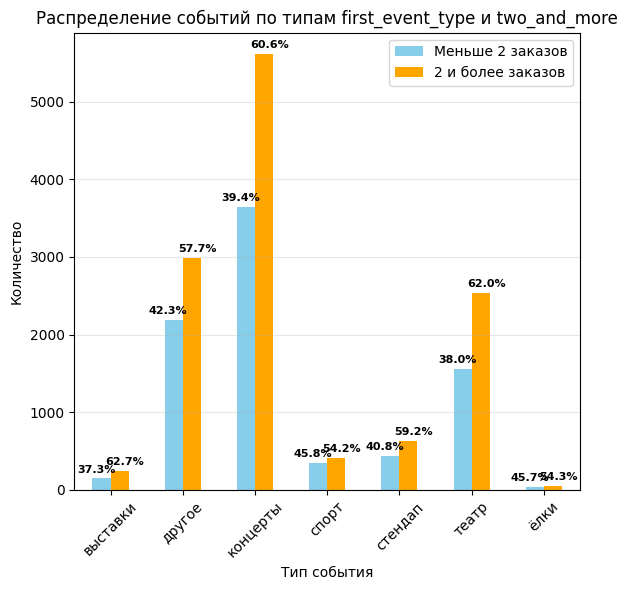

In [148]:
fig, ax = plt.subplots(figsize=(6, 6))
pivot_event.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_event_type и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# procent
for i, (idx, row) in enumerate(pivot_event.iterrows()):
    total = row.sum()
    # proc two_and_more=0
    pct_0 = (row[0] / total * 100)
    # proc two_and_more=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [149]:
pivot_device = result_user_profile.pivot_table(
    index='first_device',
    columns='two_and_more',
    values=None,
    aggfunc='size',
)

print("Количество:")
print(pivot_device)
print("\n" + "="*50 + "\n")

pivot_percentage = pivot_device.div(pivot_device.sum(axis=1), axis=0) * 100

print("Доли по строкам (% от общего для каждого события):")
print(pivot_percentage.round(2))
print("\n" + "="*50 + "\n")

pivot_total_percentage = pivot_device.div(pivot_device.sum()) * 100

print("Доли от общего количества (%):")
print(pivot_total_percentage.round(2))
print("\n" + "="*50 + "\n")

Количество:
two_and_more     0      1
first_device             
desktop       1349   2220
mobile        7025  10270


Доли по строкам (% от общего для каждого события):
two_and_more      0      1
first_device              
desktop       37.80  62.20
mobile        40.62  59.38


Доли от общего количества (%):
two_and_more      0      1
first_device              
desktop       16.11  17.77
mobile        83.89  82.23




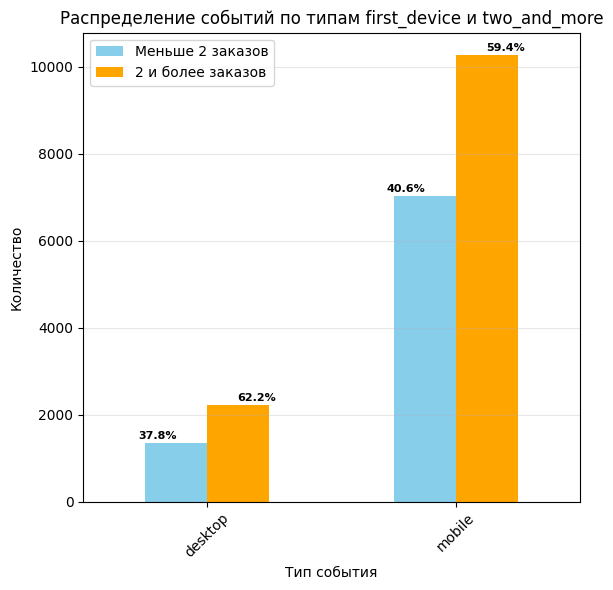

In [150]:
fig, ax = plt.subplots(figsize=(6, 6))
pivot_device.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_device и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# procent
for i, (idx, row) in enumerate(pivot_device.iterrows()):
    total = row.sum()
    # proc two_and_more=0
    pct_0 = (row[0] / total * 100)
    # proc two_and_more=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [151]:
pivot_region = result_user_profile.pivot_table(
    index='first_region',
    columns='two_and_more',
    values=None,
    aggfunc='size',
)

pivot_region = pivot_region.loc[pivot_region.sum(axis=1).sort_values(ascending=False).index]

print("Количество :")
print(pivot_region)
print("\n" + "="*50 + "\n")

pivot_percentage = pivot_region.div(pivot_region.sum(axis=1), axis=0) * 100

print("Доли по строкам (% от общего для каждого события):")
print(pivot_percentage.round(2))
print("\n" + "="*50 + "\n")

pivot_total_percentage = pivot_region.div(pivot_region.sum()) * 100

print("Доли от общего количества (%):")
print(pivot_total_percentage.round(2))
print("\n" + "="*50 + "\n")

Количество :
two_and_more                   0       1
first_region                            
Каменевский регион        2678.0  4163.0
Североярская область      1357.0  2242.0
Широковская область        434.0   759.0
Озернинский край           304.0   359.0
Малиновоярский округ       233.0   289.0
...                          ...     ...
Залесский край               1.0     1.0
Верхозёрский край            NaN     1.0
Светолесский край            1.0     NaN
Сосноводолинская область     1.0     NaN
Яснопольский округ           1.0     NaN

[81 rows x 2 columns]


Доли по строкам (% от общего для каждого события):
two_and_more                   0       1
first_region                            
Каменевский регион         39.15   60.85
Североярская область       37.70   62.30
Широковская область        36.38   63.62
Озернинский край           45.85   54.15
Малиновоярский округ       44.64   55.36
...                          ...     ...
Залесский край             50.00   50.00
Верхозёрс

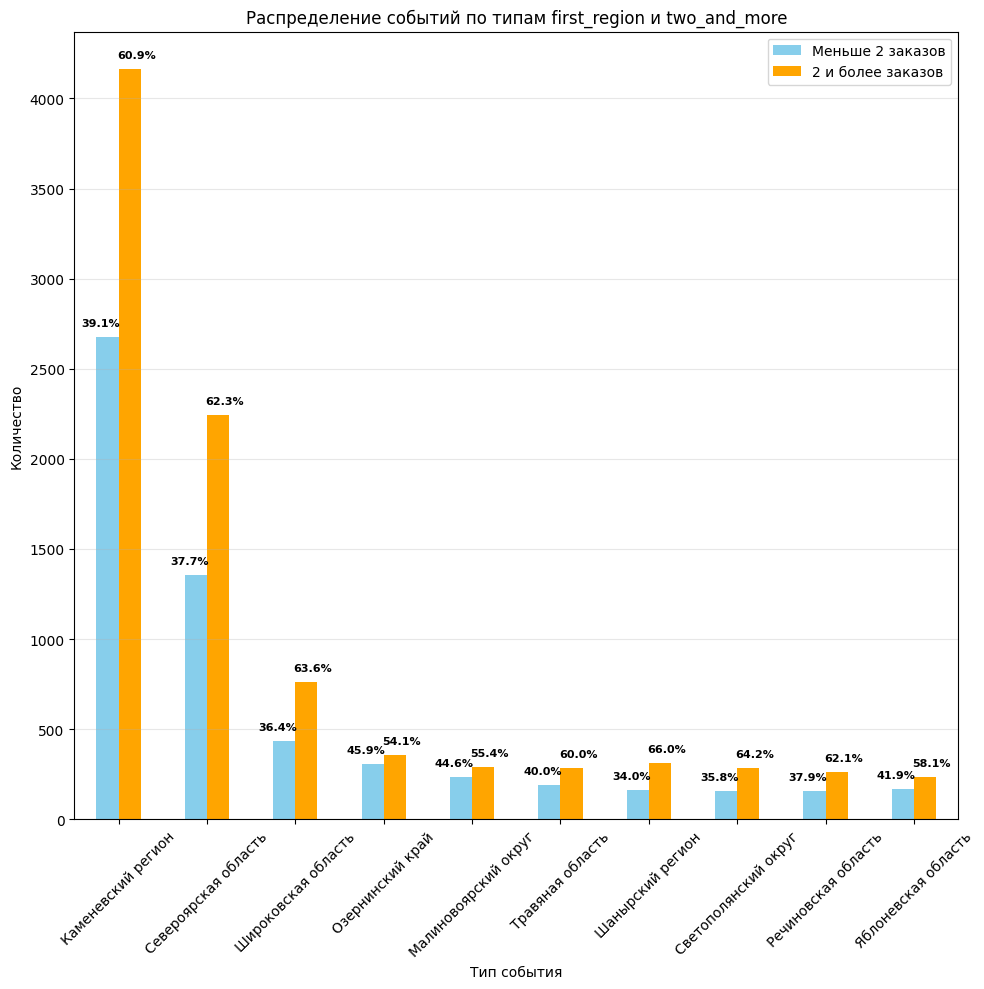

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))
pivot_region_head = pivot_region.head(10)
pivot_region_head.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_region и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# procent
for i, (idx, row) in enumerate(pivot_region_head.iterrows()):
    total = row.sum()
    # proc is_two=0
    pct_0 = (row[0] / total * 100)
    # proc is_two=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [153]:
pivot_service = result_user_profile.pivot_table(
    index='first_service',
    columns='two_and_more',
    values=None,
    aggfunc='size',
)

pivot_service = pivot_service.loc[pivot_service.sum(axis=1).sort_values(ascending=False).index]

print("Количество:")
print(pivot_service)
print("\n" + "="*50 + "\n")

pivot_percentage = pivot_service.div(pivot_service.sum(axis=1), axis=0) * 100

print("Доли по строкам (% от общего для каждого события):")
print(pivot_percentage.round(2))
print("\n" + "="*50 + "\n")

pivot_total_percentage = pivot_service.div(pivot_service.sum()) * 100

print("Доли от общего количества (%):")
print(pivot_total_percentage.round(2))
print("\n" + "="*50 + "\n")

Количество:
two_and_more                 0       1
first_service                         
Билеты без проблем      2051.0  2934.0
Мой билет               1167.0  1717.0
Лови билет!             1095.0  1620.0
Билеты в руки            952.0  1472.0
Облачко                  841.0  1272.0
Весь в билетах           480.0   768.0
Лучшие билеты            458.0   672.0
Прачечная                219.0   335.0
Край билетов             159.0   283.0
Дом культуры             125.0   214.0
Яблоко                   147.0   162.0
Тебе билет!              122.0   177.0
Городской дом культуры    89.0   122.0
За билетом!               83.0   115.0
Мир касс                  73.0   122.0
Show_ticket               58.0   103.0
Быстробилет               66.0    94.0
Выступления.ру            36.0    58.0
Восьмёрка                 27.0    56.0
Быстрый кассир             9.0    45.0
Росбилет                  19.0    32.0
Crazy ticket!             14.0    28.0
Радио ticket              21.0    15.0
Телебилет    

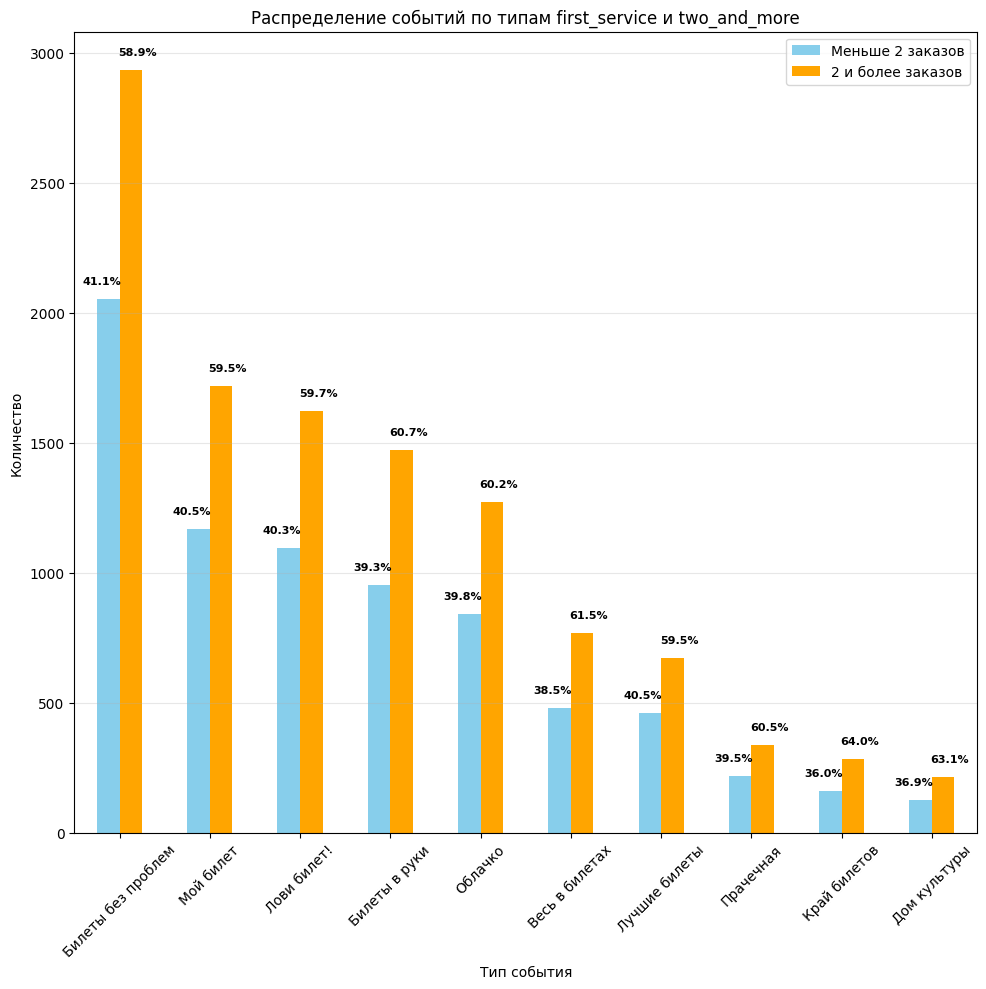

In [154]:
fig, ax = plt.subplots(figsize=(10, 10))
pivot_service_head = pivot_service.head(10)
pivot_service_head.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_service и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# procent
for i, (idx, row) in enumerate(pivot_service_head.iterrows()):
    total = row.sum()
    # proc is_two=0
    pct_0 = (row[0] / total * 100)
    # proc is_two=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

В среднем по всем сегментам процентоное соотношение вернувшихся пользователей находится в диапазоне 60 процентов, о чем свидетельствуют графики
точки Входа не обнаружены
Наиболее веротяные сегменты на повторное возвращение пользователея:
для каждого агрегированного столбца:

Концерты, Desktop-версия, Североярская Область, Билеты в Руки

##### **4.1.3 Проверка гипотез**

**`ГИПОТЕЗА 1.`**

Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

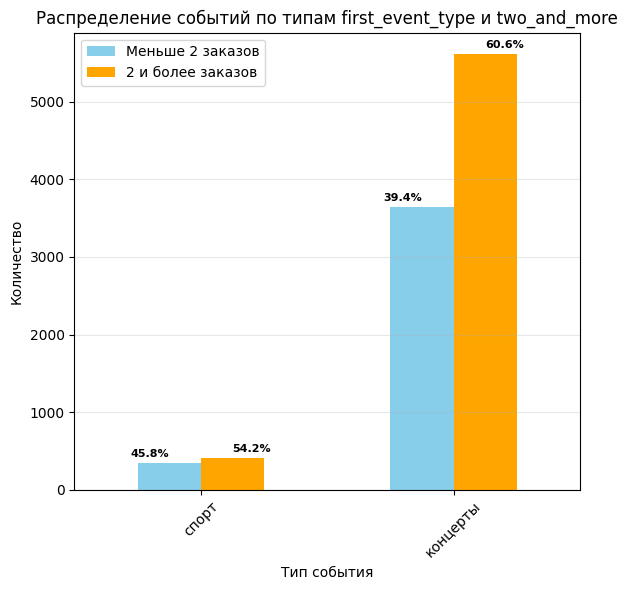

In [155]:
fig, ax = plt.subplots(figsize=(6, 6))

# Выбираем только столбцы 'спорт' и 'концерты'
selected_data = pivot_event.loc[['спорт', 'концерты']]
selected_data.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_event_type и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Добавляем проценты только для выбранных столбцов
for i, (idx, row) in enumerate(selected_data.iterrows()):
    total = row.sum()
    # proc two_and_more=0
    pct_0 = (row[0] / total * 100)
    # proc two_and_more=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

**`Гипотеза`** не подтвердилась, пользователи с первым  заказов в событии `спорт` в процентном соотношении с событием `концерты` совершают свой повторный заказ реже чем пользователи с первым заказов `концерты` 45.8% и 39.4% соответвенно

**`ГИПОТЕЗА 2`**

В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

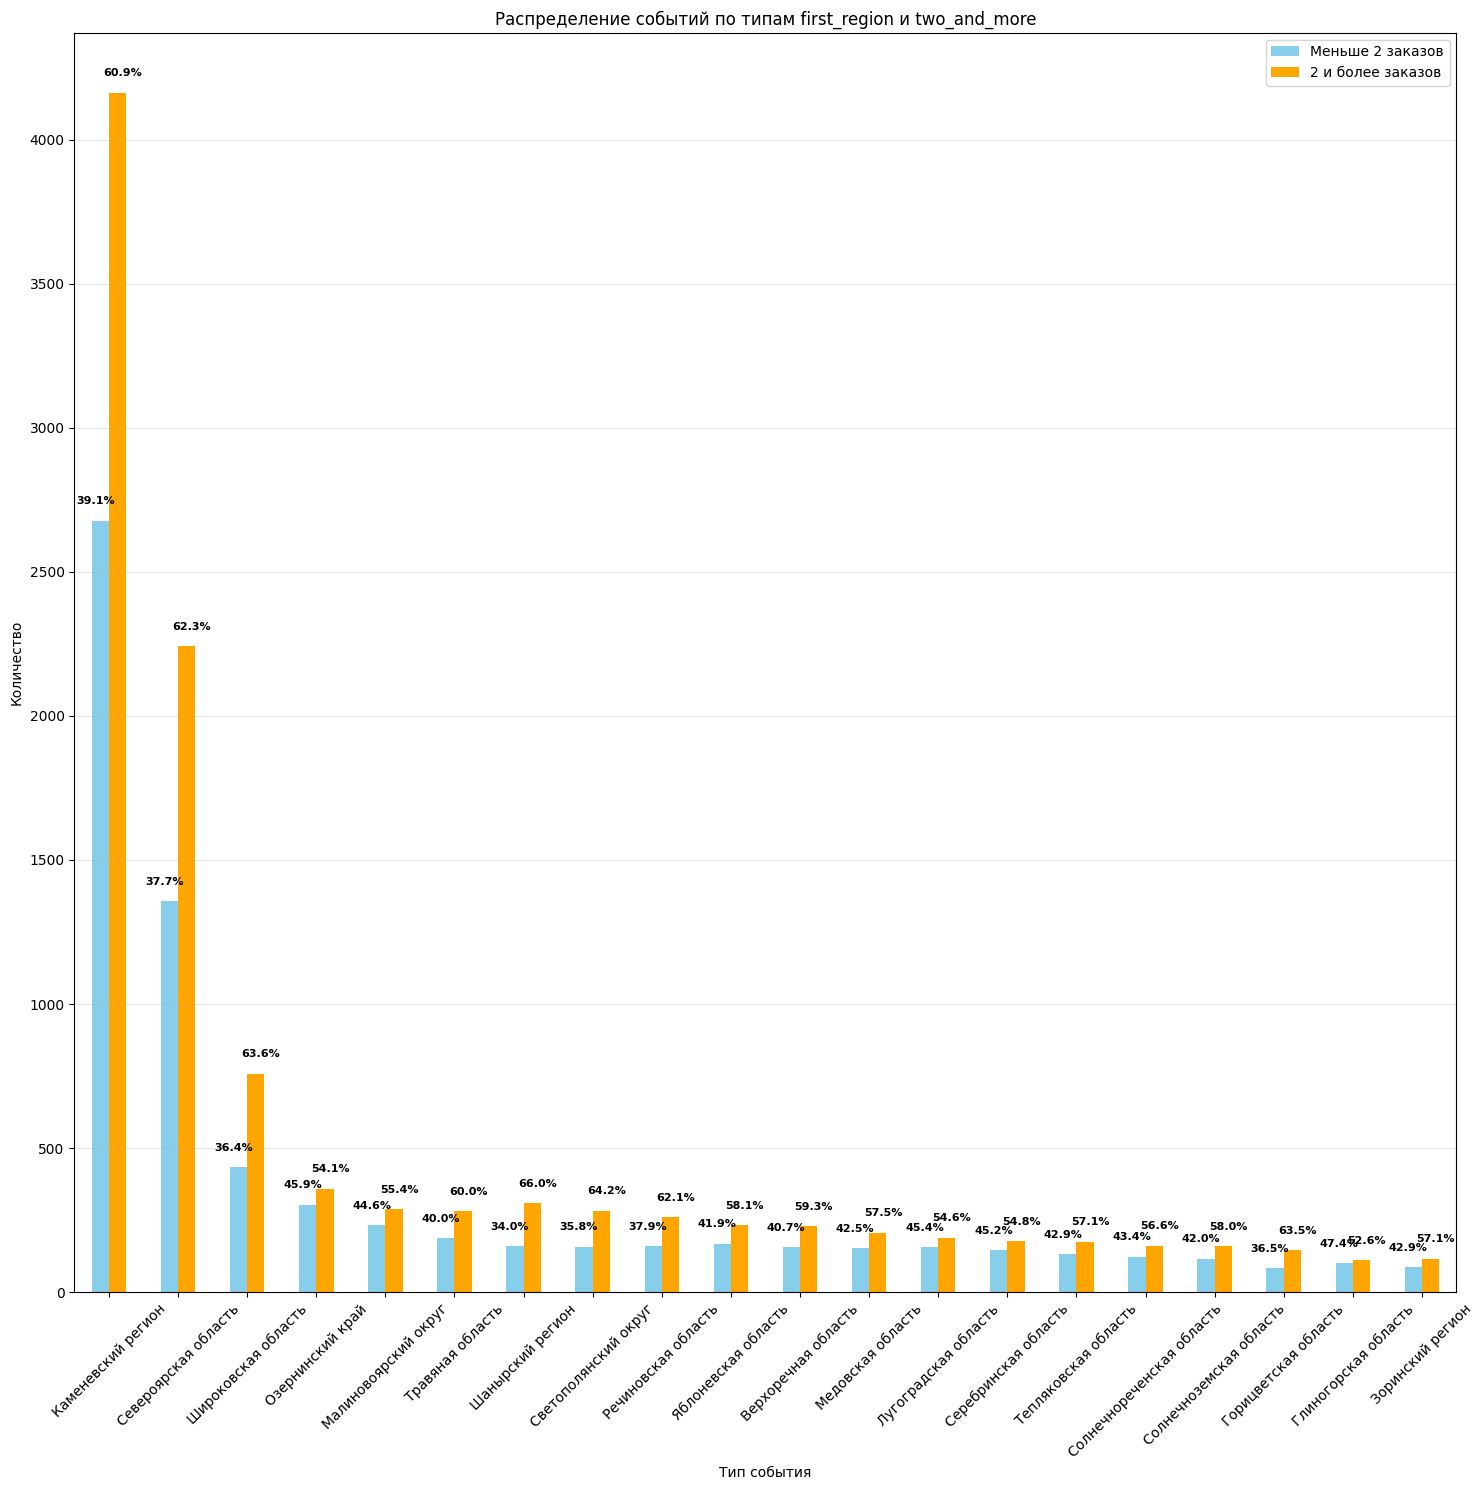

In [156]:
fig, ax = plt.subplots(figsize=(15, 15))
pivot_region_head = pivot_region.head(20)
pivot_region_head.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])

plt.title('Распределение событий по типам first_region и two_and_more')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.legend(['Меньше 2 заказов', '2 и более заказов'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# procent
for i, (idx, row) in enumerate(pivot_region_head.iterrows()):
    total = row.sum()
    # proc is_two=0
    pct_0 = (row[0] / total * 100)
    # proc is_two=1
    pct_1 = (row[1] / total * 100)

    ax.text(i - 0.2, row[0] + 50, f'{pct_0:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.2, row[1] + 50, f'{pct_1:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

За крупные возьмем области где количество заказов больше тысячи, за мелкие все остальные области ограничим больше 100 заказов, чтобы выборка была репрезентативной

In [157]:
region_totals = pivot_region.sum(axis=1)
large_regions = region_totals[region_totals > 1000]
small_regions = region_totals[(region_totals > 100) & (region_totals <= 1000)]


# Сравниваем средние доли повторных заказов
large_pct = []
small_pct = []

for region in large_regions.index:
    total = pivot_region.loc[region].sum()
    count_1 = pivot_region.loc[region, 1] if not pd.isna(pivot_region.loc[region, 1]) else 0
    pct_1 = (count_1 / total) * 100
    large_pct.append(pct_1)

for region in small_regions.index:
    total = pivot_region.loc[region].sum()
    count_1 = pivot_region.loc[region, 1] if not pd.isna(pivot_region.loc[region, 1]) else 0
    pct_1 = (count_1 / total) * 100
    small_pct.append(pct_1)

print("\nСРАВНЕНИЕ СРЕДНИХ ЗНАЧЕНИЙ:")
print("=" * 50)
print(f"Крупные регионы ({len(large_pct)} шт.):")
print(f"  Средняя доля повторных заказов: {np.mean(large_pct):.1f}%")


print(f"\nМелкие регионы ({len(small_pct)} шт.):")
print(f"  Средняя доля повторных заказов: {np.mean(small_pct):.1f}%")




СРАВНЕНИЕ СРЕДНИХ ЗНАЧЕНИЙ:
Крупные регионы (3 шт.):
  Средняя доля повторных заказов: 62.3%

Мелкие регионы (26 шт.):
  Средняя доля повторных заказов: 58.5%


**`Гипотеза`** подвердилась, В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах. хоть и не значительно(разница 4 %)

#### **4.2. Исследование поведения пользователей через показатели выручки и состава заказа**

Проведем изучение количественных характеристик заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

 ##### **4.2.1. Исследование  связи между средней выручкой сервиса с заказа и повторными заказами.**

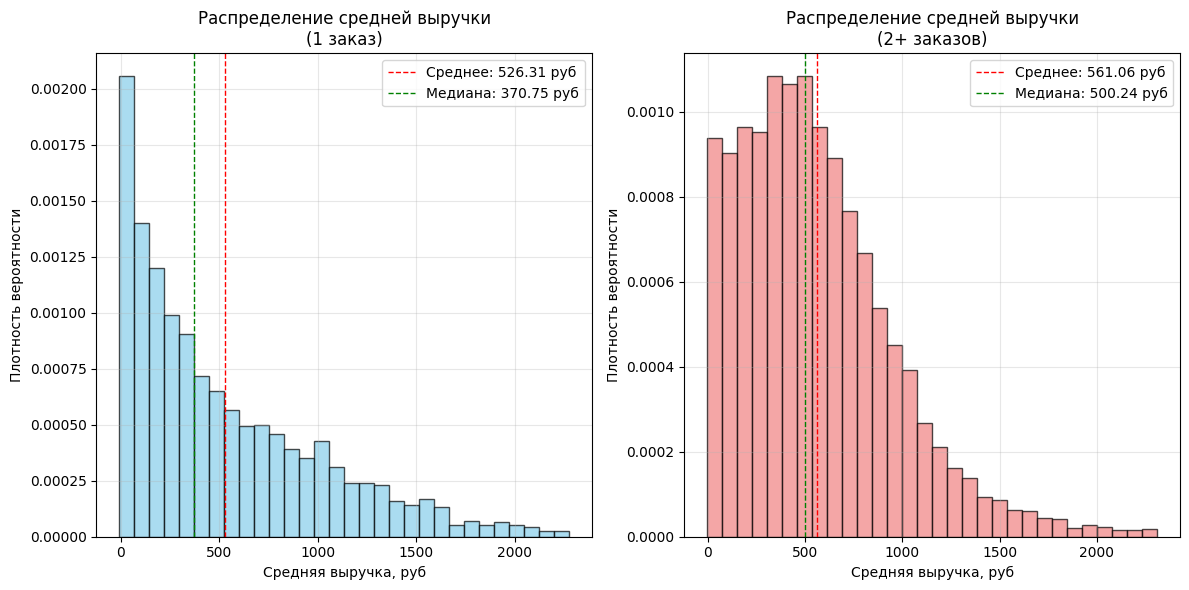

СТАТИСТИКА СРЕДНЕЙ ВЫРУЧКИ:
95-й процентиль средней выручки: 2313.84 руб
Исключены значения выше: 2313.84 руб
Оставлено 20655 из 20864 пользователей (99.0% данных)

Пользователи с 1 заказом (Колличество=8250):
  Средняя выручка: 526.31 руб
  Медианная выручка: 370.75 руб
  Стандартное отклонение: 486.79 руб
  Минимальная выручка: -10.77 руб
  Максимальная выручка: 2276.97 руб

Пользователи с 2+ заказами (Колличество=12405):
  Средняя выручка: 561.06 руб
  Медианная выручка: 500.24 руб
  Стандартное отклонение: 396.40 руб
  Минимальная выручка: -5.38 руб
  Максимальная выручка: 2311.69 руб

СРАВНЕНИЕ:
  Разница в среднем: 34.75 руб
  Относительная разница: 6.6%


In [158]:
import matplotlib.pyplot as plt
import numpy as np

revenue_99_percentile = result_user_profile['avg_revenue'].quantile(0.99)
# удаляем значение выбросы, которые влияют на анализ средних значений и распределения
filtered_data = result_user_profile[result_user_profile['avg_revenue'] <= revenue_99_percentile]

one_order = filtered_data[filtered_data['two_and_more'] == 0]['avg_revenue']
two_and_more_orders = filtered_data[filtered_data['two_and_more'] == 1]['avg_revenue']

plt.figure(figsize=(12, 6))

# hist for 1 user
plt.subplot(1, 2, 1)
plt.hist(one_order.dropna(), bins=30, color='skyblue', alpha=0.7, edgecolor='black', density=True)
plt.title('Распределение средней выручки\n(1 заказ)')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность вероятности')
plt.grid(alpha=0.3)

mean_one_order = one_order.mean()
median_one_order = one_order.median()
plt.axvline(mean_one_order, color='red', linestyle='--', linewidth=1, label=f'Среднее: {mean_one_order:.2f} руб')
plt.axvline(median_one_order, color='green', linestyle='--', linewidth=1, label=f'Медиана: {median_one_order:.2f} руб')
plt.legend()

# hist for +=2 order
plt.subplot(1, 2, 2)
plt.hist(two_and_more_orders.dropna(), bins=30, color='lightcoral', alpha=0.7, edgecolor='black', density=True)
plt.title('Распределение средней выручки\n(2+ заказов)')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность вероятности')
plt.grid(alpha=0.3)

mean_two_and_more_orders = two_and_more_orders.mean()
median_two_and_more_orders= two_and_more_orders.median()
plt.axvline(mean_two_and_more_orders, color='red', linestyle='--', linewidth=1, label=f'Среднее: {mean_two_and_more_orders:.2f} руб')
plt.axvline(median_two_and_more_orders, color='green', linestyle='--', linewidth=1, label=f'Медиана: {median_two_and_more_orders:.2f} руб')
plt.legend()

plt.tight_layout()
plt.show()

print("СТАТИСТИКА СРЕДНЕЙ ВЫРУЧКИ:")
print("=" * 60)
print(f"95-й процентиль средней выручки: {revenue_99_percentile:.2f} руб")
print(f"Исключены значения выше: {revenue_99_percentile:.2f} руб")
print(f"Оставлено {len(filtered_data)} из {len(result_user_profile)} пользователей ({len(filtered_data)/len(result_user_profile)*100:.1f}% данных)")

print(f"\nПользователи с 1 заказом (Колличество={len(one_order)}):")
print(f"  Средняя выручка: {mean_one_order:.2f} руб")
print(f"  Медианная выручка: {median_one_order:.2f} руб")
print(f"  Стандартное отклонение: {one_order.std():.2f} руб")
print(f"  Минимальная выручка: {one_order.min():.2f} руб")
print(f"  Максимальная выручка: {one_order.max():.2f} руб")

print(f"\nПользователи с 2+ заказами (Колличество={len(two_and_more_orders)}):")
print(f"  Средняя выручка: {mean_two_and_more_orders:.2f} руб")
print(f"  Медианная выручка: {median_two_and_more_orders:.2f} руб")
print(f"  Стандартное отклонение: {two_and_more_orders.std():.2f} руб")
print(f"  Минимальная выручка: {two_and_more_orders.min():.2f} руб")
print(f"  Максимальная выручка: {two_and_more_orders.max():.2f} руб")

print(f"\nСРАВНЕНИЕ:")
print(f"  Разница в среднем: {mean_two_and_more_orders - mean_one_order:.2f} руб")
print(f"  Относительная разница: {(mean_two_and_more_orders - mean_one_order) / mean_one_order * 100:.1f}%")

**Вывод**

Значения концентрируются в диапазоне от 0 до 700 рублей для группы с количеством `заказов 2 и более`

для группы с `1 заказом` от 0 до 500 рублей

Различия в группе имеются Разница в среднем: 34.75 руб это 6.6 процентов, среднее значение в средней выручки выше у группы с количеством заказов 2 и более

##### **4.2.2.**  Сравниние распределения по средней выручке с заказа в двух группах пользователей

Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;

- совершившие 5 и более заказов.

Для этого создадим новый столбец `five_and_more` состоящий из бинарных признаков 1 - 5 или более заказов, 0 - менее 5 заказов

/tmp/ipython-input-1906234822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['five_and_more'] = (result_user_profile['total_orders'] >= 5).astype(int)


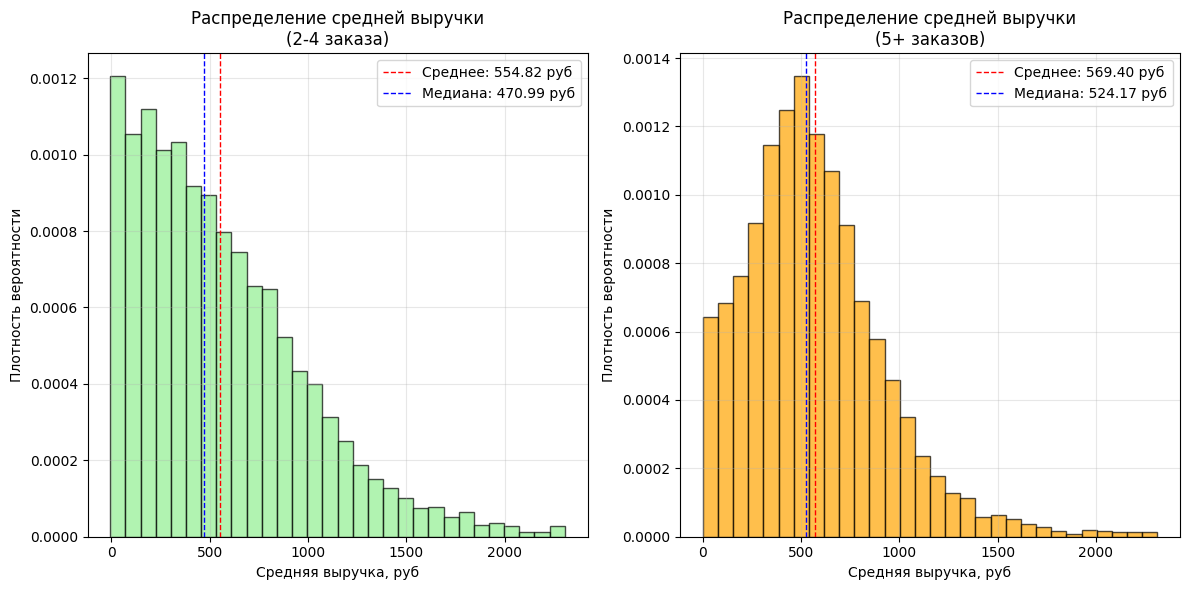

СРАВНЕНИЕ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ:
95-й процентиль средней выручки: 2313.84 руб
Исключены значения выше: 2313.84 руб

Пользователи с 2-4 заказами (N=7097):
  Средняя выручка: 554.82 руб
  Медианная выручка: 470.99 руб
  Стандартное отклонение: 426.48 руб
  Минимальная выручка: -5.38 руб
  Максимальная выручка: 2305.31 руб

Пользователи с 5+ заказами (N=5308):
  Средняя выручка: 569.40 руб
  Медианная выручка: 524.17 руб
  Стандартное отклонение: 352.06 руб
  Минимальная выручка: 0.00 руб
  Максимальная выручка: 2311.69 руб

СРАВНЕНИЕ:
  Разница в среднем: 14.57 руб
  Относительная разница: 2.6%


In [159]:
# Создаем столбец five_and_more
result_user_profile['five_and_more'] = (result_user_profile['total_orders'] >= 5).astype(int)


revenue_95_percentile = result_user_profile['avg_revenue'].quantile(0.99)

# удаляем значение выбросы, которые влияют на анализ средних значений и распределения
filtered_data = result_user_profile[result_user_profile['avg_revenue'] <= revenue_99_percentile]

# filter for 2-4 and 5=+
two_to_four_orders = filtered_data[(filtered_data['two_and_more'] == 1) & (filtered_data['five_and_more'] == 0)]['avg_revenue']
five_and_more_orders = filtered_data[filtered_data['five_and_more'] == 1]['avg_revenue']


plt.figure(figsize=(12, 6))

# hist 2-4 order
plt.subplot(1, 2, 1)
plt.hist(two_to_four_orders.dropna(), bins=30, color='lightgreen', alpha=0.7, edgecolor='black', density=True)
plt.title('Распределение средней выручки\n(2-4 заказа)')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность вероятности')
plt.grid(alpha=0.3)

mean_two_to_four = two_to_four_orders.mean()
median_two_to_four = two_to_four_orders.median()
plt.axvline(mean_two_to_four, color='red', linestyle='--', linewidth=1, label=f'Среднее: {mean_two_to_four:.2f} руб')
plt.axvline(median_two_to_four, color='blue', linestyle='--', linewidth=1, label=f'Медиана: {median_two_to_four:.2f} руб')
plt.legend()

# hist for 5=+
plt.subplot(1, 2, 2)
plt.hist(five_and_more_orders.dropna(), bins=30, color='orange', alpha=0.7, edgecolor='black', density=True)
plt.title('Распределение средней выручки\n(5+ заказов)')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность вероятности')
plt.grid(alpha=0.3)

mean_five_and_more = five_and_more_orders.mean()
median_five_and_more = five_and_more_orders.median()
plt.axvline(mean_five_and_more, color='red', linestyle='--', linewidth=1, label=f'Среднее: {mean_five_and_more:.2f} руб')
plt.axvline(median_five_and_more, color='blue', linestyle='--', linewidth=1, label=f'Медиана: {median_five_and_more:.2f} руб')
plt.legend()

plt.tight_layout()
plt.show()

print("СРАВНЕНИЕ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ:")
print("=" * 60)
print(f"95-й процентиль средней выручки: {revenue_95_percentile:.2f} руб")
print(f"Исключены значения выше: {revenue_95_percentile:.2f} руб")

print(f"\nПользователи с 2-4 заказами (N={len(two_to_four_orders)}):")
print(f"  Средняя выручка: {mean_two_to_four:.2f} руб")
print(f"  Медианная выручка: {median_two_to_four:.2f} руб")
print(f"  Стандартное отклонение: {two_to_four_orders.std():.2f} руб")
print(f"  Минимальная выручка: {two_to_four_orders.min():.2f} руб")
print(f"  Максимальная выручка: {two_to_four_orders.max():.2f} руб")

print(f"\nПользователи с 5+ заказами (N={len(five_and_more_orders)}):")
print(f"  Средняя выручка: {mean_five_and_more:.2f} руб")
print(f"  Медианная выручка: {median_five_and_more:.2f} руб")
print(f"  Стандартное отклонение: {five_and_more_orders.std():.2f} руб")
print(f"  Минимальная выручка: {five_and_more_orders.min():.2f} руб")
print(f"  Максимальная выручка: {five_and_more_orders.max():.2f} руб")

print(f"\nСРАВНЕНИЕ:")
print(f"  Разница в среднем: {mean_five_and_more - mean_two_to_four:.2f} руб")
print(f"  Относительная разница: {(mean_five_and_more - mean_two_to_four) / mean_two_to_four * 100:.1f}%")


Различия по значению средней выручки с заказа между пользователями этих двух групп отсутсвуют

##### **4.2.3. влияние среднего количества билетов в заказе на вероятность повторной покупки**

Проведем анализ распределения пользователей по среднему количеству билетов в заказе `avg_tickets_count`.

Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
- от 1 до 2 билетов;
- от 2 до 3 билетов;
- от 3 до 5 билетов;
- от 5 и более билетов.

Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

In [160]:
print("\nСТАТИСТИКА ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ:")
print("=" * 70)
print(f"Общее количество пользователей: {len(profile_of_user)}")
print(f"Среднее количество билетов: {profile_of_user['avg_tickets_count'].mean():.2f}")
print(f"Медианное количество билетов: {profile_of_user['avg_tickets_count'].median():.2f}")
print(f"Стандартное отклонение: {profile_of_user['avg_tickets_count'].std():.2f}")
print(f"Минимальное количество билетов: {profile_of_user['avg_tickets_count'].min():.0f}")
print(f"Максимальное количество билетов: {profile_of_user['avg_tickets_count'].max():.0f}")



СТАТИСТИКА ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ:
Общее количество пользователей: 21933
Среднее количество билетов: 2.76
Медианное количество билетов: 2.76
Стандартное отклонение: 0.92
Минимальное количество билетов: 1
Максимальное количество билетов: 12


Выделим сегменты:

In [161]:
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
result_user_profile['tickets_segment'] = pd.cut(result_user_profile['avg_tickets_count'],
                                          bins=bins, labels=labels, right=False)

/tmp/ipython-input-2238837156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['tickets_segment'] = pd.cut(result_user_profile['avg_tickets_count'],


In [162]:


result_user_profile['tickets_segment'] = pd.cut(result_user_profile['avg_tickets_count'],
                                          bins=bins, labels=labels, right=False)

/tmp/ipython-input-3154707869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['tickets_segment'] = pd.cut(result_user_profile['avg_tickets_count'],


/tmp/ipython-input-75922547.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = result_user_profile.groupby('tickets_segment').agg({


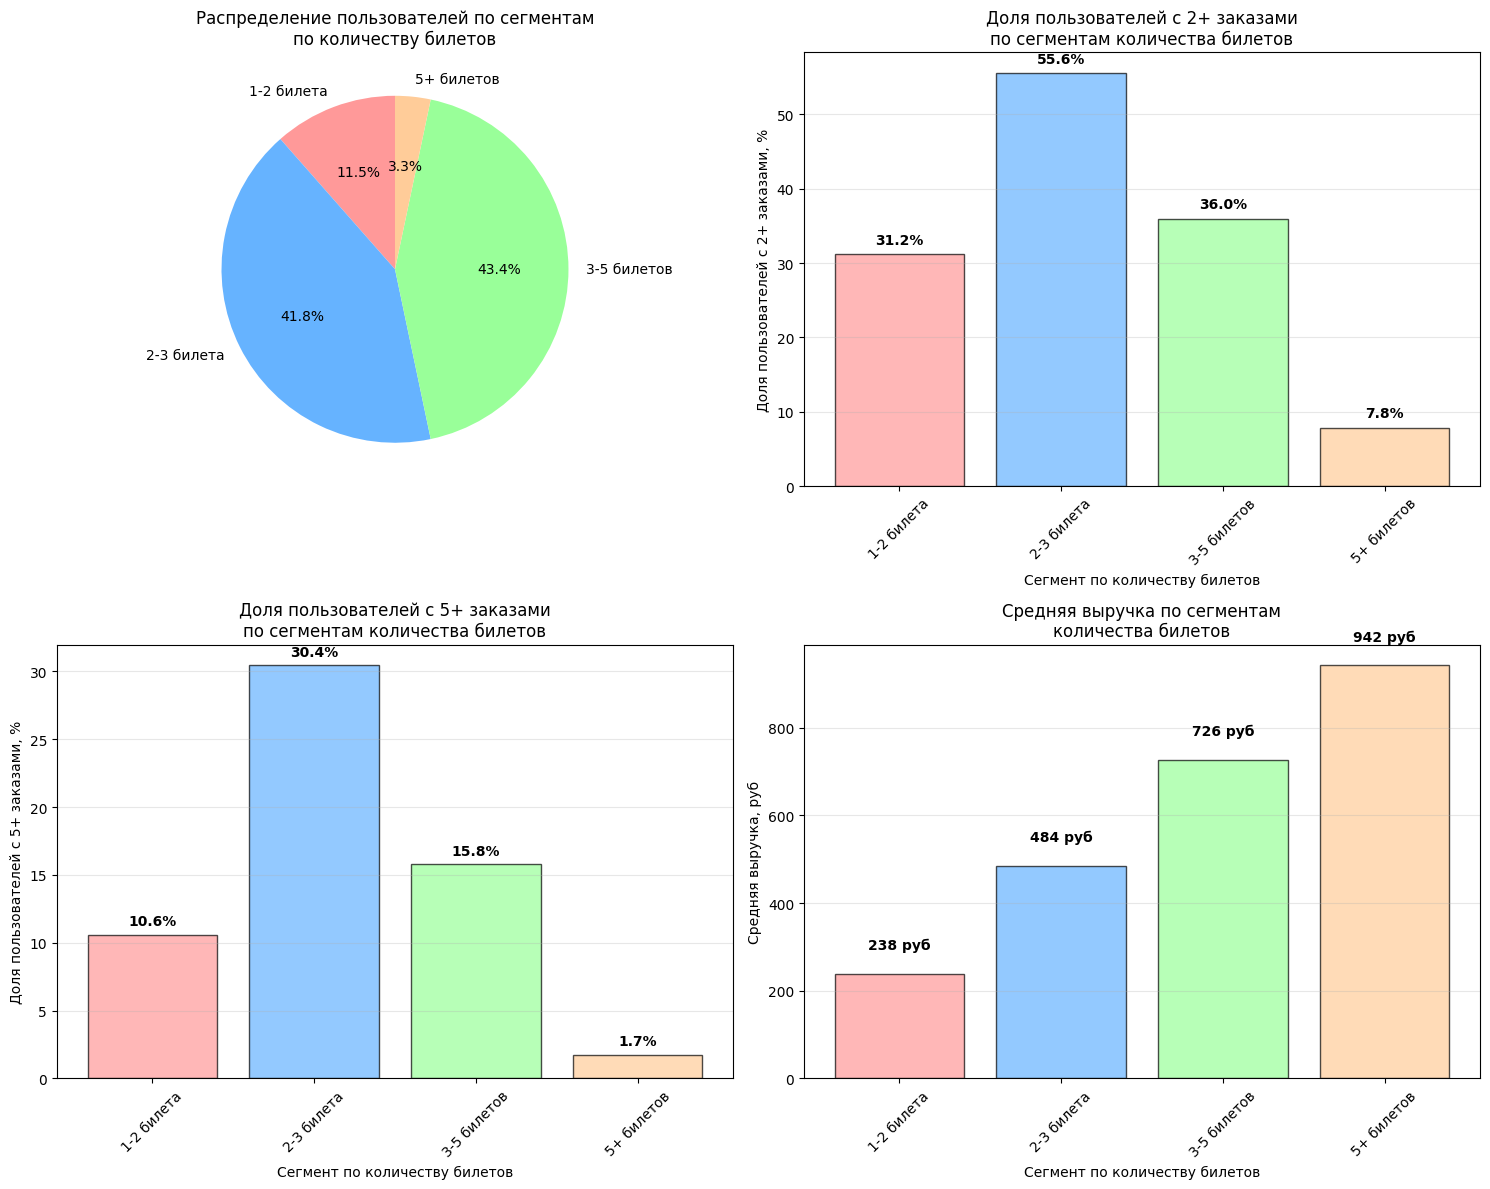

In [163]:
segment_analysis = result_user_profile.groupby('tickets_segment').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean',
    'avg_tickets_count': 'mean',
    'avg_revenue': 'mean'
}).reset_index()

segment_analysis.columns = ['tickets_segment', 'total_users', 'returning_rate', 'five_plus_rate',
                           'avg_tickets_actual', 'avg_revenue']
segment_analysis['returning_rate_pct'] = segment_analysis['returning_rate'] * 100
segment_analysis['five_plus_rate_pct'] = segment_analysis['five_plus_rate'] * 100
segment_analysis['user_share_pct'] = (segment_analysis['total_users'] / len(result_user_profile)) * 100

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Распределение пользователей по сегментам
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
wedges, texts, autotexts = ax1.pie(segment_analysis['total_users'],
                                   labels=segment_analysis['tickets_segment'],
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Распределение пользователей по сегментам\nпо количеству билетов')

# Доля возвращающихся пользователей по сегментам
bars1 = ax2.bar(segment_analysis['tickets_segment'], segment_analysis['returning_rate_pct'],
                color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Доля пользователей с 2+ заказами\nпо сегментам количества билетов')
ax2.set_xlabel('Сегмент по количеству билетов')
ax2.set_ylabel('Доля пользователей с 2+ заказами, %')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Доля пользователей с 5+ заказами по сегментам
bars2 = ax3.bar(segment_analysis['tickets_segment'], segment_analysis['five_plus_rate_pct'],
                color=colors, alpha=0.7, edgecolor='black')
ax3.set_title('Доля пользователей с 5+ заказами\nпо сегментам количества билетов')
ax3.set_xlabel('Сегмент по количеству билетов')
ax3.set_ylabel('Доля пользователей с 5+ заказами, %')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Средняя выручка по сегментам
bars3 = ax4.bar(segment_analysis['tickets_segment'], segment_analysis['avg_revenue'],
                color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('Средняя выручка по сегментам\nколичества билетов')
ax4.set_xlabel('Сегмент по количеству билетов')
ax4.set_ylabel('Средняя выручка, руб')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{height:.0f} руб', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

- Распределение пользователей по сегментам количества билетов

**Анализ распределения пользователей по среднему количеству билетов в заказе выявил четкую сегментацию:**

- Доминирующие сегменты: Пользователи с 2-3 билетами (44%) и 3-5 билетами (42%) формируют основную массу клиентской базы, составляя вместе 86% от всех пользователей.

- Меньшинство сегментов:

  - Пользователи с 1-2 билетами - 10%

  - Пользователи с 5+ билетами - всего 3.1%

Такое распределение свидетельствует о том, что типичный заказ включает от 2 до 5 билетов, что соответствует покупкам для небольших компаний или семей.

Влияние на вероятность повторных покупок (2+ заказов)
Количество билетов в заказе существенно влияет на вероятность повторных покупок:

Наиболее лояльный сегмент: Пользователи с 2-3 билетами демонстрируют наивысшую долю возвращаемости - 60%

Средние показатели:

3-5 билетов: 37% возвращаемости

1-2 билета: 31% возвращаемости

Наименее лояльный сегмент: Пользователи с 5+ билетами показывают значительно более низкую долю возвращаемости - 7.8%

Влияние на формирование высокой лояльности (5+ заказов)
Анализ пользователей с высокой лояльностью (5+ заказов) подтверждает выявленные закономерности:

Лидер по лояльности: Сегмент 2-3 билета сохраняет лидирующие позиции

Минимальная лояльность: Пользователи с 5+ билетами демонстрируют крайне низкий показатель - всего 1.7%

Взаимосвязь с выручкой
Наблюдается прямая зависимость между количеством билетов и средней выручкой:

Равномерный рост: С увеличением количества билетов в заказе происходит пропорциональный рост средней выручки

Экономическая логика: Распределение соответствует ожидаемой модели - больше билетов = выше общая стоимость заказа

Оптимальный сегмент: Пользователи, приобретающие 2-3 билета за заказ, являются наиболее ценными - они составляют значительную долю базы и демонстрируют наивысшие показатели лояльности.
крупные- заказов: Несмотря на высокую среднюю выручку, пользователи с 5+ билетами показывают низкую возвращаемость, что может свидетельствовать о разовых крупных покупках.


### **4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки**

Изучим временные параметры, связанные с первым заказом пользователей:
- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами

##### **4.3.1. Анализ, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей**

По данным даты первого заказа выделим день недели.
Для каждого дня недели подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

In [164]:
result_user_profile['first_order_weekday'] = result_user_profile['first_order_date'].dt.day_name()

/tmp/ipython-input-1659975983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['first_order_weekday'] = result_user_profile['first_order_date'].dt.day_name()


Зададим порядок дней недели для корректного отображения

In [165]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result_user_profile['first_order_weekday'] = pd.Categorical(
    result_user_profile['first_order_weekday'],
    categories=weekday_order,
    ordered=True
)

/tmp/ipython-input-1298984666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['first_order_weekday'] = pd.Categorical(


/tmp/ipython-input-1706881478.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_analysis = result_user_profile.groupby('first_order_weekday').agg({


     weekday  total_users  returning_users  returning_proc
0     Monday         2825             1746           61.81
1    Tuesday         3056             1848           60.47
2  Wednesday         2976             1819           61.12
3   Thursday         3039             1774           58.37
4     Friday         3185             1873           58.81
5   Saturday         3129             1887           60.31
6     Sunday         2654             1543           58.14


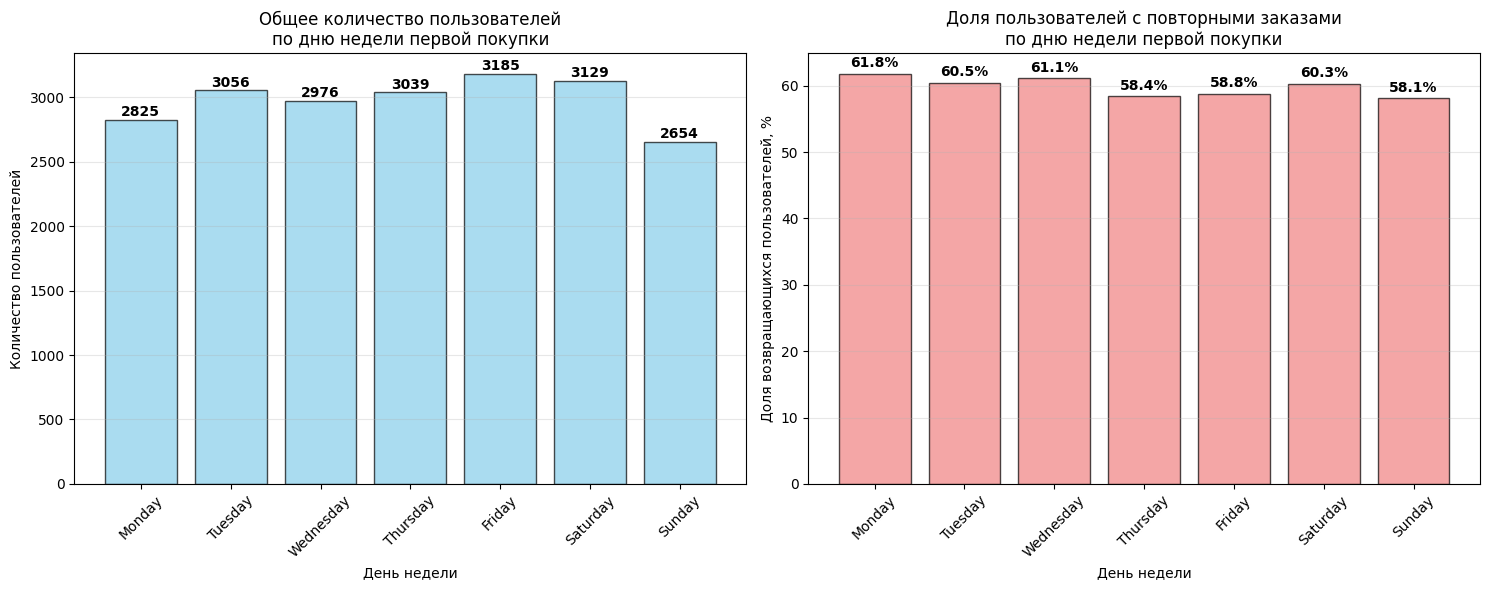

In [166]:
weekday_analysis = result_user_profile.groupby('first_order_weekday').agg({
    'user_id': 'count',
    'two_and_more': 'sum'
}).reset_index()

weekday_analysis.columns = ['weekday', 'total_users', 'returning_users']
weekday_analysis['returning_proc'] = (weekday_analysis['returning_users'] / weekday_analysis['total_users']) * 100

print("=" * 60)
print(weekday_analysis.round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# plot count for days of week
bars1 = ax1.bar(weekday_analysis['weekday'], weekday_analysis['total_users'],
                color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_title('Общее количество пользователей\nпо дню недели первой покупки')
ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# plot 2 v procentah
bars2 = ax2.bar(weekday_analysis['weekday'], weekday_analysis['returning_proc'],
                color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_title('Доля пользователей с повторными заказами\nпо дню недели первой покупки')
ax2.set_xlabel('День недели')
ax2.set_ylabel('Доля возвращающихся пользователей, %')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


  Лучший день для первой покупки: Monday

    - Доля возвращающихся: 61.8%
    - Всего пользователей: 2825

  Худший день для первой покупки: Sunday

    - Доля возвращающихся: 58.1%
    - Всего пользователей: 2654

**ВЫВОД**

Пользователи распределены равномерно в выделенных сегментах

Аномалий при анализе не обнаружено

Влияние дня недели на возвращение клиента не обнаруженно

##### **4.3.2 Изучим, как средний интервал между заказами влияет на удержание клиентов.**

Рассчитаем среднее время между заказами для двух групп пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа

In [167]:
two_to_four_orders = result_user_profile[(result_user_profile['total_orders'] >= 2) &
                                   (result_user_profile['total_orders'] <= 4)]

five_and_more_orders = result_user_profile[result_user_profile['total_orders'] >= 5]

Выведем статистику:

In [168]:
print("=" * 60)
print(f"Всего пользователей с 2+ заказами: {len(result_user_profile[result_user_profile['total_orders'] >= 2])}")
print(f"  - с 2-4 заказами: {len(two_to_four_orders)}")
print(f"  - с 5+ заказами: {len(five_and_more_orders)}")


print("\nСТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:")
print("=" * 60)

print(f"Пользователи с 2-4 заказами:")
print(f"  Средний интервал: {two_to_four_orders['avg_days_between_orders'].mean():.1f} дней")
print(f"  Медианный интервал: {two_to_four_orders['avg_days_between_orders'].median():.1f} дней")
print(f"  Стандартное отклонение: {two_to_four_orders['avg_days_between_orders'].std():.1f} дней")
print(f"  Минимальный интервал: {two_to_four_orders['avg_days_between_orders'].min():.1f} дней")
print(f"  Максимальный интервал: {two_to_four_orders['avg_days_between_orders'].max():.1f} дней")

print(f"\nПользователи с 5+ заказами:")
print(f"  Средний интервал: {five_and_more_orders['avg_days_between_orders'].mean():.1f} дней")
print(f"  Медианный интервал: {five_and_more_orders['avg_days_between_orders'].median():.1f} дней")
print(f"  Стандартное отклонение: {five_and_more_orders['avg_days_between_orders'].std():.1f} дней")
print(f"  Минимальный интервал: {five_and_more_orders['avg_days_between_orders'].min():.1f} дней")
print(f"  Максимальный интервал: {five_and_more_orders['avg_days_between_orders'].max():.1f} дней")

Всего пользователей с 2+ заказами: 12490
  - с 2-4 заказами: 7159
  - с 5+ заказами: 5331

СТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:
Пользователи с 2-4 заказами:
  Средний интервал: 12.1 дней
  Медианный интервал: 5.0 дней
  Стандартное отклонение: 15.5 дней
  Минимальный интервал: -0.5 дней
  Максимальный интервал: 73.5 дней

Пользователи с 5+ заказами:
  Средний интервал: 9.5 дней
  Медианный интервал: 8.5 дней
  Стандартное отклонение: 6.3 дней
  Минимальный интервал: -0.2 дней
  Максимальный интервал: 29.8 дней


Построим график:

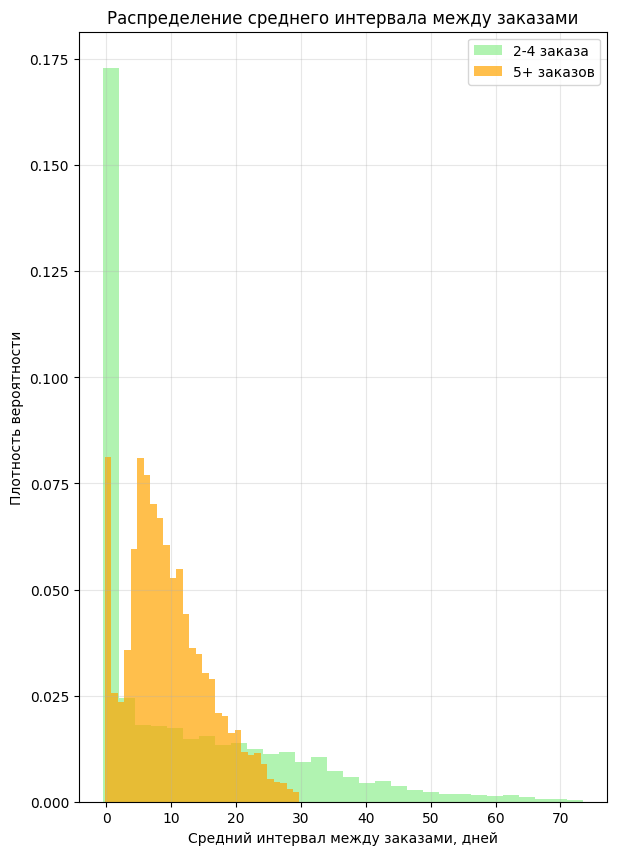

In [169]:

plt.figure(figsize=(15, 10))

# histogrm
plt.subplot(1, 2, 1)
plt.hist(two_to_four_orders['avg_days_between_orders'].dropna(), bins=30,
         alpha=0.7, color='lightgreen', label='2-4 заказа', density=True)
plt.hist(five_and_more_orders['avg_days_between_orders'].dropna(), bins=30,
         alpha=0.7, color='orange', label='5+ заказов', density=True)
plt.title('Распределение среднего интервала между заказами')
plt.xlabel('Средний интервал между заказами, дней')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(alpha=0.3)


/tmp/ipython-input-3105792160.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['2-4 заказа', '5+ заказов'])


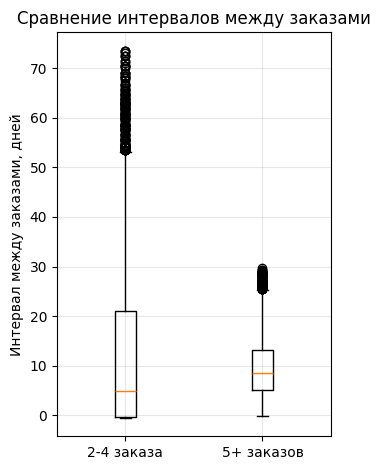

In [170]:
plt.subplot(1, 2, 2)
data_to_plot = [
    two_to_four_orders['avg_days_between_orders'].dropna(),
    five_and_more_orders['avg_days_between_orders'].dropna()
]
plt.boxplot(data_to_plot, labels=['2-4 заказа', '5+ заказов'])
plt.title('Сравнение интервалов между заказами')
plt.ylabel('Интервал между заказами, дней')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Влияние среднего интервала между заказами `5+`:

/tmp/ipython-input-3924815871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['interval_category'] = pd.cut(result_user_profile['avg_days_between_orders'],
/tmp/ipython-input-3924815871.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interval_analysis = result_user_profile[result_user_profile['total_orders'] >= 2].groupby('interval_category').agg({


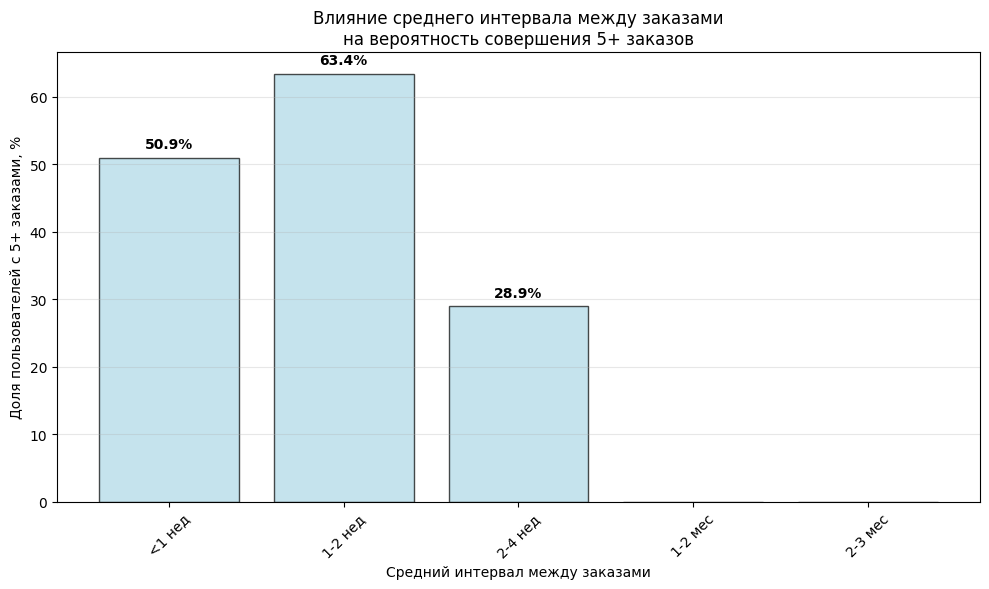

In [171]:
bins = [0, 7, 14, 30, 60, 90, 180, 365, float('inf')]
labels = ['<1 нед', '1-2 нед', '2-4 нед', '1-2 мес', '2-3 мес', '3-6 мес', '6-12 мес', '>12 мес']

result_user_profile['interval_category'] = pd.cut(result_user_profile['avg_days_between_orders'],
                                            bins=bins, labels=labels, right=False)

# interval 5+
interval_analysis = result_user_profile[result_user_profile['total_orders'] >= 2].groupby('interval_category').agg({
    'user_id': 'count',
    'is_five': 'mean',
    'avg_days_between_orders': 'mean'
}).reset_index()

interval_analysis.columns = ['interval_category', 'user_count', 'five_plus_rate', 'avg_interval']
interval_analysis['five_plus_rate_pct'] = interval_analysis['five_plus_rate'] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(interval_analysis['interval_category'].astype(str),
               interval_analysis['five_plus_rate_pct'],
               color='lightblue', alpha=0.7, edgecolor='black')
plt.title('Влияние среднего интервала между заказами\nна вероятность совершения 5+ заказов')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Доля пользователей с 5+ заказами, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    if not pd.isna(height) and height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


`Пользователи с 2-4 заказами`
- Средний интервал между заказами: 12 дней

- Наиболее частый интервал: 5 дней после предыдущего заказа

- Характерная особенность: Высокая вариативность в длительности интервалов между заказами

- Пиковая активность: Большое количество повторных заказов совершается в первые 3 дня после первого заказа

- Стабильность поведения: Низкая - наблюдается значительный разброс в периодичности покупок

`Пользователи с 5+ заказами`
- Средний интервал между заказами: 9 дней

- Характерная особенность: Стабильная и предсказуемая периодичность совершения заказов

- Стабильность поведения: Высокая - пользователи демонстрируют регулярную активность с похожей периодичностью
- Сегмент 5+ совершают повторные заказы в интервал между 0 дней и 1-2 недели

### **4.4. Корреляционный анализ количества покупок и признаков пользователя**

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используем универсальный коэффициент корреляции phi_k, который позволяет анализировать как числовые, так и категориальные признаки.

##### **4.4.1 Корреляционный анализ:**

Рассчитаем коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов `total_orders`.




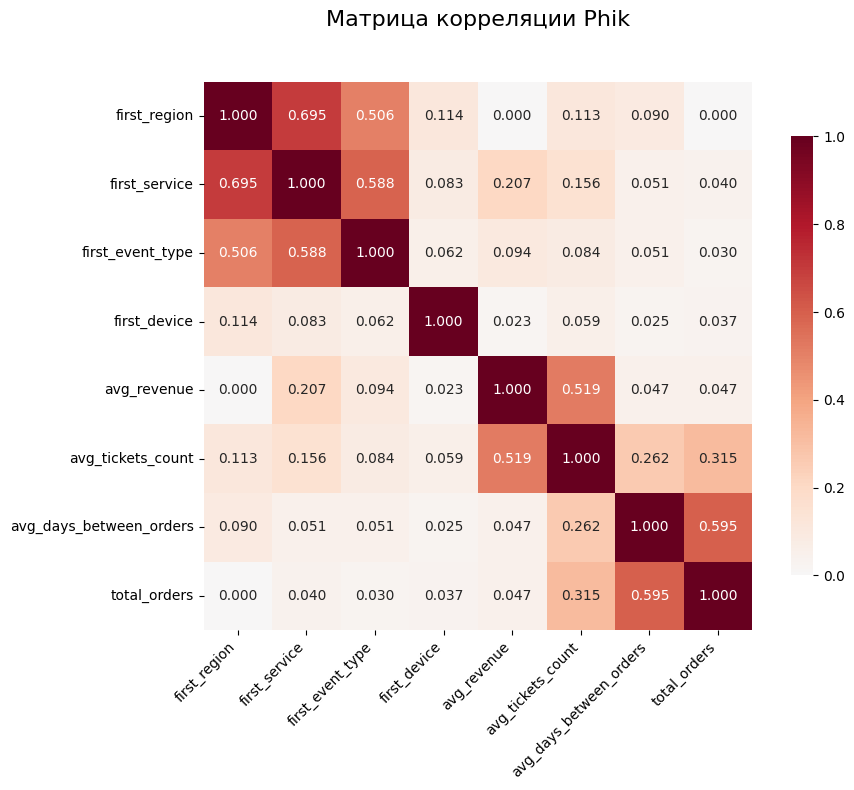

In [172]:
from phik import phik_matrix

# определяем типы данных в столбцы
categor = ['first_region', 'first_service', 'first_event_type', 'first_device']
interval = ['avg_revenue', 'avg_tickets_count', 'avg_days_between_orders', 'total_orders']

# corr
corr_data = result_user_profile[categor + interval]
phik_corr = corr_data.phik_matrix(interval_cols=interval)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, cbar_kws={'shrink': 0.8})

plt.title('Матрица корреляции Phik', fontsize=16, pad=40)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Средняя корреляция — `total_orders` и `avg_days_between_orders` - 0.595
Слабая корреляция — `total_orders` и `avg_tickets_count` - 0.315

Свидетельствует о том, что вероятность возврата клиента зависит от количества дней прошедших с момента заказа и колличества купленных билетов

Выведем отдельную линейную зависимость для каждой корреляции


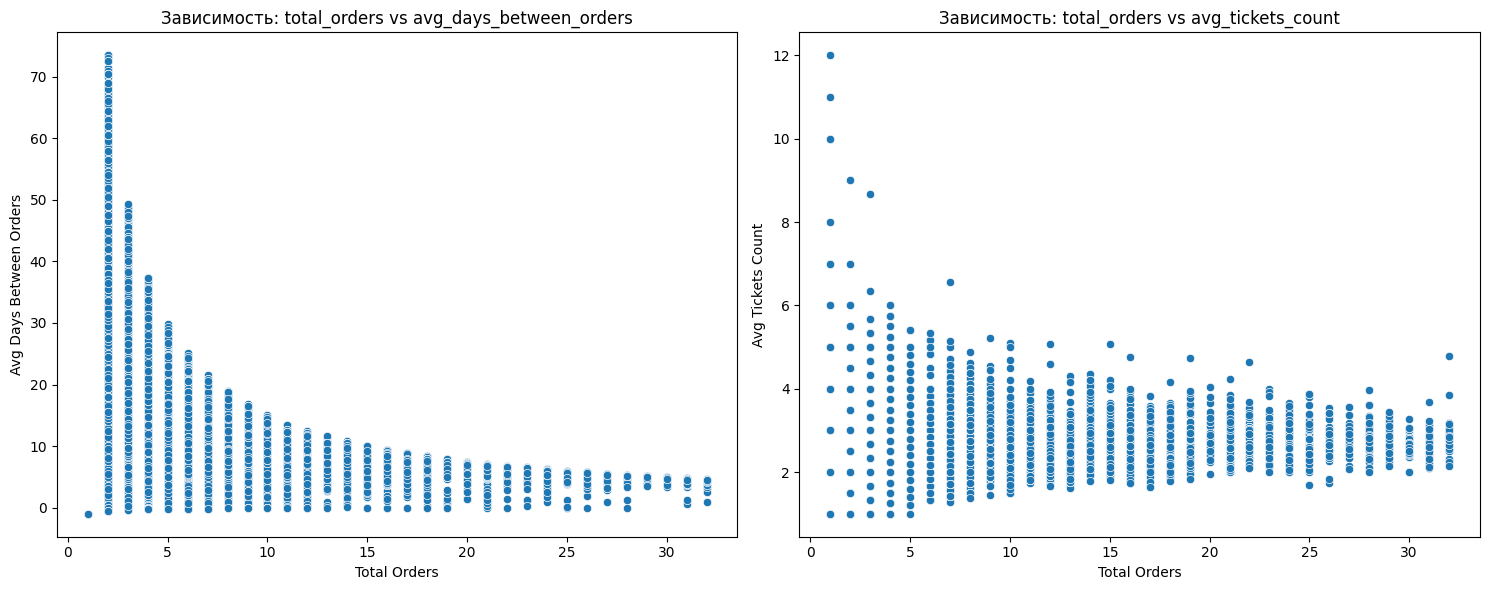

In [173]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# total_orders и avg_days_between_orders
sns.scatterplot(data=result_user_profile, x='total_orders', y='avg_days_between_orders', ax=ax1)
ax1.set_title('Зависимость: total_orders vs avg_days_between_orders')
ax1.set_xlabel('Total Orders')
ax1.set_ylabel('Avg Days Between Orders')

#  total_orders и avg_tickets_count
sns.scatterplot(data=result_user_profile, x='total_orders', y='avg_tickets_count', ax=ax2)
ax2.set_title('Зависимость: total_orders vs avg_tickets_count')
ax2.set_xlabel('Total Orders')
ax2.set_ylabel('Avg Tickets Count')

plt.tight_layout()
plt.show()

**ВЫВОДЫ**
- пользователи чаще всего возвращаются если количество купленных ими билетов достигает 5 штук

- Зависимость возвращения пользователя от дней между заказами: с увеличением колличества заказов, колличество дней между заказами уменьшается

/tmp/ipython-input-4005211904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_user_profile['segment'] = pd.cut(result_user_profile['total_orders'],
/usr/local/lib/python3.12/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable avg_days_between_orders for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(


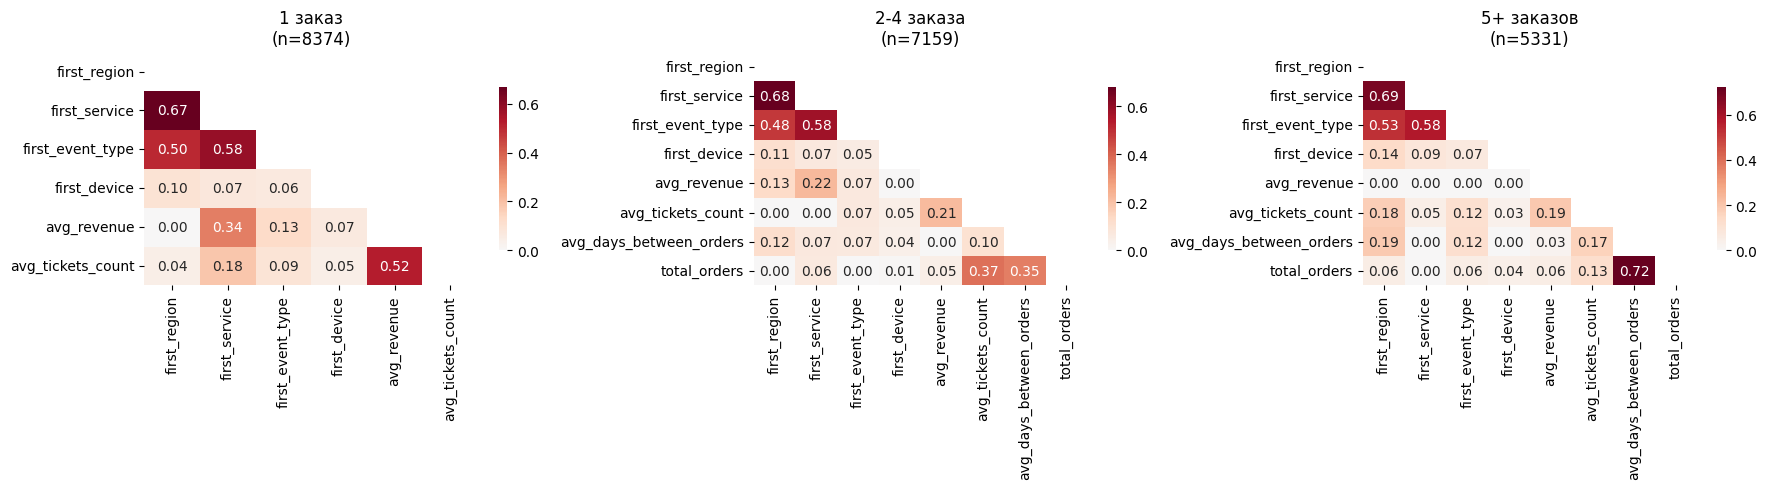

In [174]:
# Создаем сегменты
result_user_profile['segment'] = pd.cut(result_user_profile['total_orders'],
                                      bins=[0, 1, 4, float('inf')],
                                      labels=['1 заказ', '2-4 заказа', '5+ заказов'])

# Анализ для каждого сегмента
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cols = categor + interval

for i, segment in enumerate(result_user_profile['segment'].cat.categories):
    data = result_user_profile[result_user_profile['segment'] == segment][cols]
    corr = data.phik_matrix(interval_cols=interval)

    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                mask=np.triu(np.ones_like(corr)), ax=axes[i], cbar_kws={'shrink': 0.7})
    axes[i].set_title(f'{segment}\n(n={len(data)})')

plt.tight_layout()
plt.show()

При делении на сегменты ранее сделанные выводы подтвердились

### 🔽 **5. Общие выводы и рекомендации**


🔽 1. **Подготовка данных**
- В рамках анализа была проведена комплексная обработка данных о 29 061 заказе, включая:

    - Конвертацию валюты (тенге в рубли по актуальному курсу)

    - Замену пропущенных значений индикатором '-1'

    - Фильтрацию аномалий (удалено 4.87% записей)

    - Создание профилей пользователей с 12 ключевыми метриками

    - Итоговая выборка: 20 864 пользователя с полной историей покупок.

2. **Ключевые статистические показатели**
- Средняя выручка на заказ: 574 рубля

- Процент лояльных пользователей:

    - Совершили 2+ заказов: 45.49%

    - Совершили 5+ заказов: 24.71%

- Распределение по первому заказу:

    - Концерты (44.36%), мобильное приложение (82.9%)

    - Топ-регион: Каменевский (32.79%)

3. **Влияние характеристик первого заказа на возврат**
- Наиболее перспективные сегменты:
    - Тип мероприятия: Концерты (высокая доля возвращающихся)

    - Устройство: Desktop-версия (показывает лучшие показатели удержания)

    - Регион: Североярская область

    - Билетный оператор: "Билеты в руки"

4. **Критические факторы удержания:**
- Количество билетов в заказе:

    - Оптимальный диапазон: 2-3 билета (60% возвращаемости)

    - Сегмент 5+ билетов показывает низкую лояльность (7.8%) несмотря на высокий чек

- Временные паттерны:

    - Пользователи с 5+ заказами демонстрируют стабильные интервалы (9 дней в среднем)

    - Сильная отрицательная корреляция между количеством заказов и интервалами между ними (-0.595)

- Доходы:

    - Разница в средней выручке между одноразовыми и постоянными клиентами составляет 6.6%

    - Прямая зависимость между количеством билетов и выручкой

5. **Рекомендации**
- Приоритетные сегменты для удержания:
    - Пользователи с 2-4 заказами - ключевой растущий сегмент

    - Внедрить программу лояльности для стимулирования 5-го заказа

    - Персонализированные предложения на основе предпочтений

    - Покупатели 2-3 билетов - наиболее лояльная группа

    - Разработать семейные/групповые предложения

    - Система рекомендаций на основе истории посещений

- Маркетинговые усилия для проблемных сегментов:
    - Покупатели 5+ билетов - высокий чек, но низкая лояльность

    - Исследовать причины низкого возврата возможны корпоративные покупки для организаций

    - Создать программу для крупных групповых заказов

- Пользователи с длинными интервалами (12+ дней)

    - рассылки перед вероятным временем следующего заказа

    - Персональные скидки для возвращения

- точеки входа:
    - Усилить контентную стратегию по концертам (основной драйвер первого заказа)

    - Улучшить пользовательский опыт desktop-версии (высокий потенциал удержания)

    - Разработать партнерскую программу с топовыми билетными операторами

